In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import IPython.display as ipd
#import os
#model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models/'])
model_dir = "./models/"
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_weight_penalty, prune_plot
import copy
from tensorboardX import SummaryWriter

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()
use_cuda = torch.cuda.is_available()

#arguments
model_name = 'LeNet_300_100'
training_epochs=20
retraining_epochs=50
temp_list = [1, 5, 10, 15, 20, 25, 30]

## LeNet 300-100

### 1. Train Model

In [2]:
def trueAfterN(ip, N):
    return ((N-1)==ip%N)

In [24]:
def show_sws_weights(model, means, precisions):
    weights = np.array([], dtype=np.float32)
    for layer in model.state_dict():
        weights = np.hstack( (weights, model.state_dict()[layer].view(-1).cpu().numpy()) )
    plt.clf()
    plt.figure(figsize=(18, 3))
    sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True)
    
    #plot for 0
    plt.axvline(0, linewidth = 1)
    std_dev0 = np.sqrt(1/np.exp(precisions.pop(0)))
    plt.axvspan(xmin=-std_dev0, xmax=std_dev0, alpha=0.3)
    
    for mean, precision in zip(means, precisions):
        plt.axvline(mean, linewidth = 1)
        std_dev = np.sqrt(1/np.exp(precision))
        plt.axvspan(xmin=mean - std_dev, xmax=mean + std_dev, alpha=0.3)
    plt.show()
    
#show_sws_weights(model, list(gmp.means.data.clone().cpu()), list(gmp.gammas.data.clone().cpu()))

In [4]:
def show_all_weights(model):
    weights = np.array([], dtype=np.float32)
    for layer in model.state_dict():
        weights = np.hstack( (weights, model.state_dict()[layer].view(-1).cpu().numpy()) )
    plt.clf()
    plt.figure(figsize=(18, 3))
    sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})
    plt.show()
    
#show_all_weights(model)

In [5]:
def show_weights(model):
    weight_list = [x for x in model.state_dict().keys() if 'weight' in x]
    plt.clf()
    plt.figure(figsize=(18, 3))
    for i,weight in enumerate(weight_list):
        plt.subplot(131 + i)
        fc_w = model.state_dict()[weight]
        sns.distplot(fc_w.view(-1).cpu().numpy(), kde=False, color="g",bins=200,norm_hist=True)
        plt.title('Layer: {}'.format(weight))
    plt.show()
    
#show_weights(model)

In [17]:
def logsumexp(t, w=1, axis=1):
    #print (t.shape)
    t_max, _ = t.max(dim=1)
    if (axis==1):
        t = t-t_max.repeat(t.size(1), 1).t()
    else:
        t = t-t_max.repeat(1, t.size(0)).t()
    t = w * t.exp()
    t = t.sum(dim=axis)
    t.log_()
    return t + t_max

class GaussianMixturePrior(Module):
    def __init__(self, nb_components, network_weights, pi_zero, **kwargs):
        super(GaussianMixturePrior, self).__init__()
        
        self.nb_components = nb_components 
        self.network_weights = [p.view(-1) for p in network_weights]
        self.pi_zero = pi_zero
        
        #Build
        J = self.nb_components
        pi_zero = self.pi_zero
        
        #    ... means
        init_means = torch.linspace(-0.6, 0.6, J - 1)
        self.means = Variable(init_means.cuda(), requires_grad=True)
        
        #precision
        init_stds = torch.FloatTensor(np.tile(0.25, J) )
        self.gammas = Variable( (- torch.log(torch.pow(init_stds, 2))).cuda(), requires_grad=True)
        
        #mixing proportions
        init_mixing_proportions = torch.ones((J - 1))
        init_mixing_proportions *= (1. - pi_zero) / (J - 1)
        self.rhos = Variable((init_mixing_proportions).cuda(), requires_grad=True)
        self.print_batch=True
        #self.loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        
    def call(self, mask=None):
        J=self.nb_components
        loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        means = torch.cat(( Variable(torch.cuda.FloatTensor([0.]), requires_grad=True) , self.means), 0)
        #mean=self.means
        precision = self.gammas.exp()
        
        min_rho = self.rhos.min()
        mixing_proportions = (self.rhos - min_rho).exp()
        mixing_proportions = (1 - self.pi_zero) * mixing_proportions/mixing_proportions.sum()
        mixing_proportions = torch.pow(mixing_proportions, 2)
        mixing_proportions = torch.cat(( Variable(torch.cuda.FloatTensor([self.pi_zero])) , mixing_proportions), 0)
        
        for weights in self.network_weights:
            weight_loss = self.compute_loss(weights, mixing_proportions, means, precision)
            if(gmp.print_batch):
                print ("Layer Loss: {:.3f}".format(float(weight_loss.data)))
            loss = loss + weight_loss
        
        
        # GAMMA PRIOR ON PRECISION
        # ... for the zero component
        
        #Replacing gather with indexing -- same calculation?
        (alpha, beta) = (5e3,20e-1)
        #print (torch.gather(self.gammas, 0, Variable(torch.cuda.LongTensor([0,1,2]))))
        neglogprop = (1 - alpha) * self.gammas[0] + beta * precision[0]
        if(gmp.print_batch):
            print ("0-neglogprop Loss: {:.3f}".format(float(neglogprop.data)))
        loss = loss + neglogprop.sum()
        # ... and all other component
        alpha, beta = (2.5e2,1e-1)
        neglogprop = (1 - alpha) * self.gammas[1:J] + beta * precision[1:J]
        if(gmp.print_batch):
            print ("Remaining-neglogprop Loss: {:.3f}".format(float(neglogprop.sum().data)))
        loss = loss + neglogprop.sum()
        gmp.print_batch=False
        return loss
        
        
    def compute_loss(self, weights, mixing_proportions, means, precision):
        diff = weights.expand(means.size(0), -1) - means.expand(weights.size(0), -1).t()
        unnormalized_log_likelihood = (-(diff ** 2)/2).t() * precision
        #unnormalized_log_likelihood = (-1/2) * precision.matmul((diff ** 2))
        Z = precision.sqrt() / (2 * np.pi)
        #global myt
        #myt=unnormalized_log_likelihood
        log_likelihood = logsumexp(unnormalized_log_likelihood, w=(mixing_proportions * Z), axis=1)
        return -log_likelihood.sum()

In [21]:
def train_epoch_sws(model, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader):
    """
    train model
    
    model: neural network model
    optimizer: optimization algorithm/configuration
    criterion: loss function
    train_loader: training dataset dataloader
    """
    model.train()
    gmp.print_batch = True
    for i, (images, labels) in enumerate(train_loader):
        #if(use_cuda):
        images=images.cuda()
        labels=labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        optimizer_gmp.zero_grad()
        optimizer_gmp2.zero_grad()
        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        #loss = criterion(outputs, labels) + 0.001 * ( (model.fc1.weight - 0.05).norm() + (model.fc2.weight - 0.05).norm() + (model.fc3.weight - 0.05).norm() + (model.fc1.weight + 0.05).norm() + (model.fc2.weight + 0.05).norm() + (model.fc3.weight + 0.05).norm())
        loss = criterion(outputs, labels)
        #print (criterion(outputs, labels))
        #print (gmp.call())
        # Getting gradients w.r.t. parameters
        gmp_loss = 5e-7 * gmp.call()
        loss.backward()
        gmp_loss.backward()
        # Updating parameters
        optimizer.step()
        optimizer_gmp.step()
        optimizer_gmp2.step()
    return model, criterion(outputs, labels)

**Default Training**

**Epoch: 1**

Layer Loss: 147291.625
Layer Loss: 165.992
Layer Loss: 21380.977
Layer Loss: 63.684
Layer Loss: 998.946
Layer Loss: 5.666
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -10331.617
Epoch: 1. Loss: 1.4622858762741089. Accuracy: 98.21
Means: [-0.643, -0.552, -0.451, -0.349, -0.248, -0.157, -0.073, -0.007, 0.07, 0.155, 0.242, 0.33, 0.418, 0.506, 0.596]
Mixing Proportions: [1.086, 0.498, -0.75, -0.755, -0.675, -0.578, -0.512, -0.496, -0.538, -0.637, -0.76, -0.819, -0.835, -0.839, -0.838]
Precisions: [3.412, 3.462, 3.474, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476, 3.476]


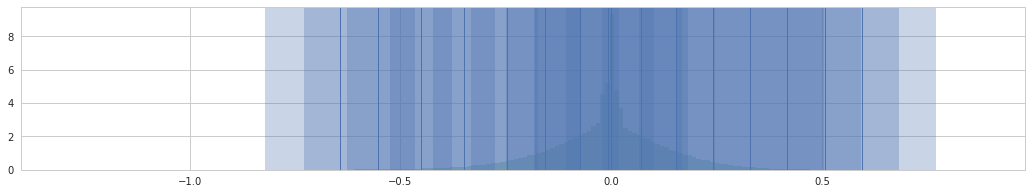

**Epoch: 2**

Layer Loss: 100733.836
Layer Loss: 93.442
Layer Loss: 18074.938
Layer Loss: 47.117
Layer Loss: 1143.373
Layer Loss: 3.393
0-neglogprop Loss: -16995.350
Remaining-neglogprop Loss: -12931.733
Epoch: 2. Loss: 1.4611505270004272. Accuracy: 98.22
Means: [-0.69, -0.568, -0.466, -0.367, -0.255, -0.156, -0.07, -0.009, 0.066, 0.151, 0.239, 0.33, 0.429, 0.54, 0.642]
Mixing Proportions: [2.524, -1.083, -2.146, -2.14, -2.06, -1.966, -1.903, -1.888, -1.927, -2.022, -2.14, -2.195, -2.21, -2.211, -2.205]
Precisions: [3.845, 4.167, 4.176, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177, 4.177]


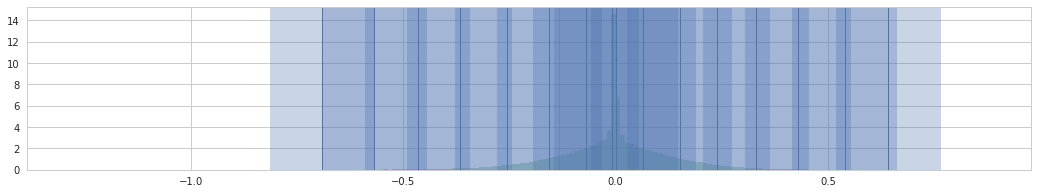

**Epoch: 3**

Layer Loss: 76451.609
Layer Loss: 54.302
Layer Loss: 18252.121
Layer Loss: 42.496
Layer Loss: 1389.373
Layer Loss: 2.257
0-neglogprop Loss: -19127.717
Remaining-neglogprop Loss: -15499.582
Epoch: 3. Loss: 1.4611506462097168. Accuracy: 98.25
Means: [-0.675, -0.569, -0.469, -0.37, -0.257, -0.156, -0.07, -0.009, 0.065, 0.15, 0.24, 0.332, 0.442, 0.587, 0.705]
Mixing Proportions: [3.168, -1.746, -2.789, -2.781, -2.701, -2.607, -2.544, -2.529, -2.568, -2.662, -2.78, -2.835, -2.85, -2.844, -2.753]
Precisions: [4.072, 4.784, 4.871, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.869, 4.868]


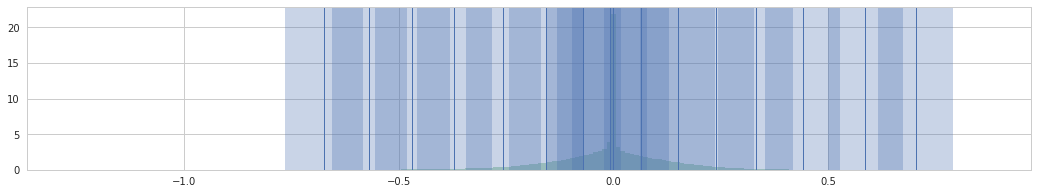

**Epoch: 4**

Layer Loss: 62881.508
Layer Loss: 37.647
Layer Loss: 19015.699
Layer Loss: 42.683
Layer Loss: 1562.763
Layer Loss: 1.843
0-neglogprop Loss: -20237.465
Remaining-neglogprop Loss: -17970.518
Epoch: 4. Loss: 1.4611510038375854. Accuracy: 98.19
Means: [-0.645, -0.569, -0.469, -0.372, -0.257, -0.156, -0.069, -0.009, 0.065, 0.15, 0.24, 0.332, 0.445, 0.624, 0.765]
Mixing Proportions: [3.53, -2.142, -3.177, -3.169, -3.088, -2.994, -2.931, -2.916, -2.955, -3.049, -3.167, -3.222, -3.237, -3.222, -2.572]
Precisions: [4.195, 4.971, 5.547, 5.545, 5.544, 5.544, 5.544, 5.544, 5.544, 5.544, 5.544, 5.544, 5.544, 5.544, 5.544, 5.542]


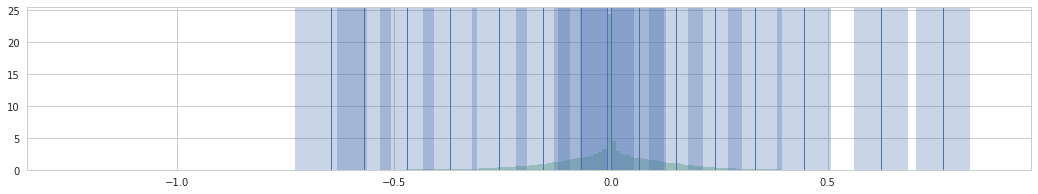

**Epoch: 5**

Layer Loss: 51923.195
Layer Loss: 28.998
Layer Loss: 19220.111
Layer Loss: 43.005
Layer Loss: 1661.756
Layer Loss: 1.658
0-neglogprop Loss: -20838.984
Remaining-neglogprop Loss: -20193.010
Epoch: 5. Loss: 1.4611506462097168. Accuracy: 98.19
Means: [-0.627, -0.569, -0.47, -0.372, -0.257, -0.156, -0.069, -0.009, 0.065, 0.15, 0.24, 0.332, 0.447, 0.651, 0.785]
Mixing Proportions: [3.741, -2.436, -3.467, -3.458, -3.377, -3.284, -3.221, -3.206, -3.245, -3.339, -3.456, -3.512, -3.526, -3.502, -1.502]
Precisions: [4.291, 4.967, 6.189, 6.186, 6.186, 6.185, 6.185, 6.185, 6.185, 6.185, 6.185, 6.185, 6.185, 6.185, 6.185, 6.185]


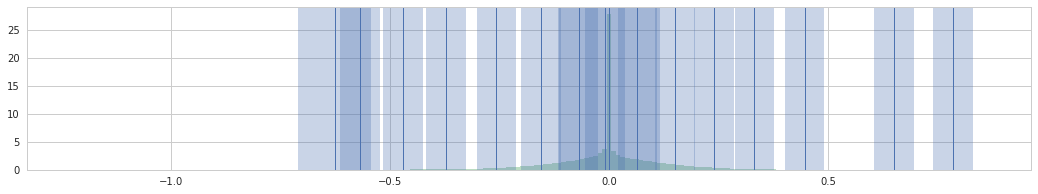

**Epoch: 6**

Layer Loss: 41606.598
Layer Loss: 22.266
Layer Loss: 19141.697
Layer Loss: 42.989
Layer Loss: 1736.763
Layer Loss: 1.518
0-neglogprop Loss: -21303.049
Remaining-neglogprop Loss: -22105.543
Epoch: 6. Loss: 1.4611519575119019. Accuracy: 98.18
Means: [-0.612, -0.569, -0.47, -0.373, -0.257, -0.156, -0.069, -0.009, 0.065, 0.15, 0.24, 0.332, 0.448, 0.666, 0.754]
Mixing Proportions: [3.888, -2.683, -3.712, -3.703, -3.622, -3.528, -3.465, -3.45, -3.489, -3.583, -3.701, -3.756, -3.77, -3.738, -0.539]
Precisions: [4.381, 4.941, 6.766, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.762, 6.754]


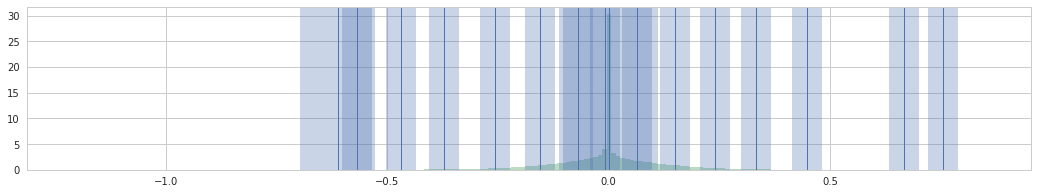

**Epoch: 7**

Layer Loss: 31353.289
Layer Loss: 16.166
Layer Loss: 18931.029
Layer Loss: 42.508
Layer Loss: 1808.163
Layer Loss: 1.370
0-neglogprop Loss: -21739.734
Remaining-neglogprop Loss: -23577.488
Epoch: 7. Loss: 1.4611506462097168. Accuracy: 98.15
Means: [-0.599, -0.569, -0.47, -0.373, -0.257, -0.156, -0.069, -0.009, 0.065, 0.15, 0.24, 0.332, 0.449, 0.666, 0.749]
Mixing Proportions: [4.064, -2.896, -3.922, -3.913, -3.832, -3.738, -3.675, -3.661, -3.7, -3.793, -3.911, -3.966, -3.981, -3.942, -0.246]
Precisions: [4.471, 4.914, 7.233, 7.23, 7.229, 7.229, 7.229, 7.229, 7.229, 7.229, 7.229, 7.229, 7.229, 7.229, 7.229, 7.203]


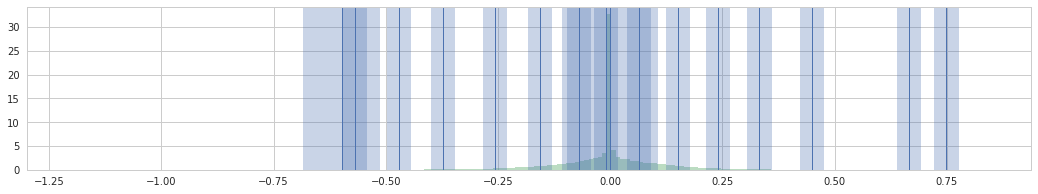

**Epoch: 8**

Layer Loss: 20923.207
Layer Loss: 10.217
Layer Loss: 18627.076
Layer Loss: 41.709
Layer Loss: 1879.893
Layer Loss: 1.228
0-neglogprop Loss: -22173.648
Remaining-neglogprop Loss: -24477.967
Epoch: 8. Loss: 1.4717912673950195. Accuracy: 98.06
Means: [-0.586, -0.569, -0.47, -0.373, -0.257, -0.156, -0.069, -0.009, 0.065, 0.15, 0.24, 0.332, 0.45, 0.656, 0.751]
Mixing Proportions: [4.234, -3.079, -4.103, -4.094, -4.013, -3.919, -3.856, -3.842, -3.88, -3.974, -4.091, -4.146, -4.161, -4.1, -0.172]
Precisions: [4.562, 4.885, 7.551, 7.549, 7.549, 7.548, 7.548, 7.548, 7.548, 7.548, 7.548, 7.548, 7.548, 7.548, 7.549, 7.518]


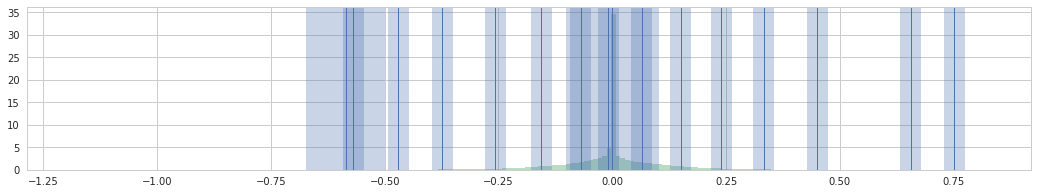

**Epoch: 9**

Layer Loss: 10267.907
Layer Loss: 4.301
Layer Loss: 18245.727
Layer Loss: 40.465
Layer Loss: 1954.580
Layer Loss: 1.080
0-neglogprop Loss: -22613.566
Remaining-neglogprop Loss: -24858.418
Epoch: 9. Loss: 1.4611505270004272. Accuracy: 98.07
Means: [-0.574, -0.569, -0.47, -0.373, -0.257, -0.157, -0.069, -0.008, 0.065, 0.15, 0.24, 0.332, 0.451, 0.638, 0.753]
Mixing Proportions: [4.382, -3.24, -4.263, -4.254, -4.173, -4.079, -4.016, -4.002, -4.04, -4.134, -4.251, -4.306, -4.321, -4.195, -0.103]
Precisions: [4.654, 4.853, 7.721, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.72, 7.703]


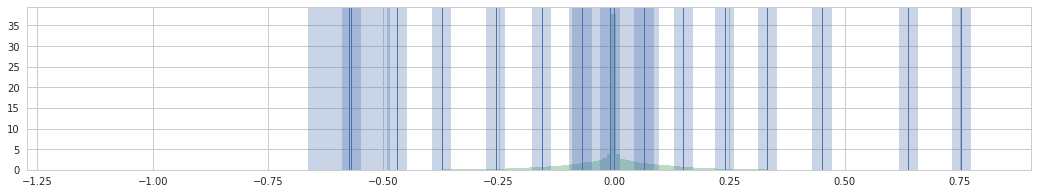

**Epoch: 10**

Layer Loss: -543.633
Layer Loss: -1.327
Layer Loss: 17816.543
Layer Loss: 38.817
Layer Loss: 2033.339
Layer Loss: 0.900
0-neglogprop Loss: -23056.898
Remaining-neglogprop Loss: -24952.928
Epoch: 10. Loss: 1.4611506462097168. Accuracy: 98.1
Means: [-0.562, -0.569, -0.47, -0.373, -0.257, -0.157, -0.069, -0.008, 0.065, 0.15, 0.24, 0.333, 0.454, 0.625, 0.754]
Mixing Proportions: [4.51, -3.387, -4.409, -4.399, -4.318, -4.225, -4.162, -4.147, -4.186, -4.28, -4.397, -4.452, -4.467, -4.15, -0.04]
Precisions: [4.747, 4.814, 7.791, 7.79, 7.79, 7.79, 7.79, 7.79, 7.79, 7.79, 7.79, 7.79, 7.79, 7.79, 7.791, 7.792]


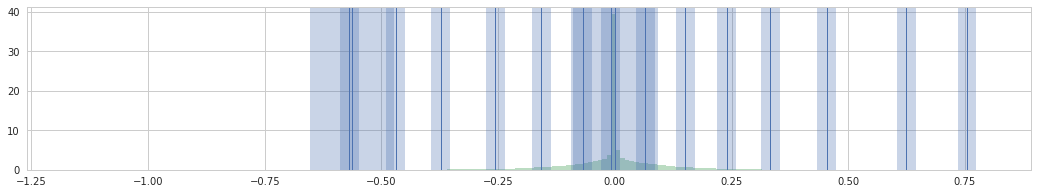

**Epoch: 11**

Layer Loss: -11459.249
Layer Loss: -6.820
Layer Loss: 17376.061
Layer Loss: 37.166
Layer Loss: 2116.717
Layer Loss: 0.762
0-neglogprop Loss: -23500.867
Remaining-neglogprop Loss: -24959.582
Epoch: 11. Loss: 1.4611506462097168. Accuracy: 98.11
Means: [-0.55, -0.569, -0.47, -0.374, -0.257, -0.157, -0.069, -0.008, 0.065, 0.15, 0.24, 0.333, 0.46, 0.61, 0.755]
Mixing Proportions: [4.578, -3.525, -4.546, -4.536, -4.456, -4.362, -4.299, -4.285, -4.324, -4.417, -4.534, -4.589, -4.604, -3.257, -0.022]
Precisions: [4.844, 4.768, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.813, 7.815, 7.827]


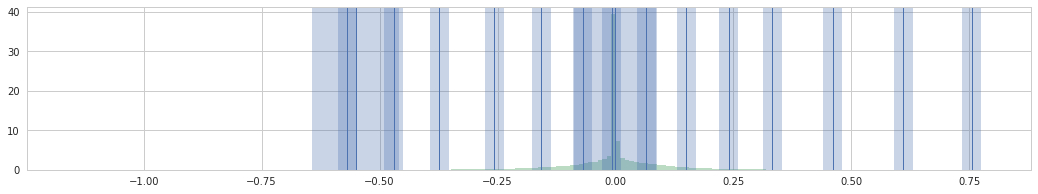

**Epoch: 12**

Layer Loss: -22738.105
Layer Loss: -12.321
Layer Loss: 16885.893
Layer Loss: 35.059
Layer Loss: 2207.328
Layer Loss: 0.591
0-neglogprop Loss: -23959.568
Remaining-neglogprop Loss: -24950.109
Epoch: 12. Loss: 1.4819880723953247. Accuracy: 98.15
Means: [-0.538, -0.569, -0.47, -0.374, -0.257, -0.157, -0.069, -0.008, 0.065, 0.15, 0.24, 0.333, 0.509, 0.558, 0.756]
Mixing Proportions: [4.163, -3.689, -4.709, -4.699, -4.618, -4.525, -4.462, -4.447, -4.486, -4.579, -4.696, -4.751, -4.762, -0.786, -0.42]
Precisions: [4.943, 4.719, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.819, 7.808, 7.84]


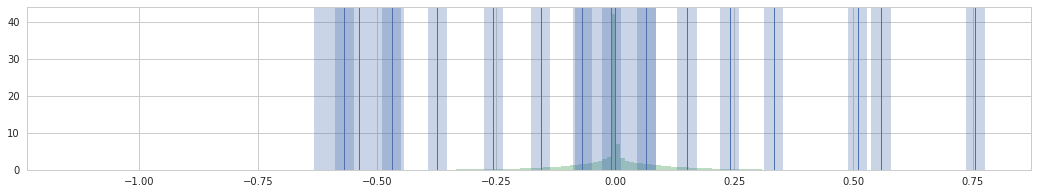

**Epoch: 13**

Layer Loss: -34071.258
Layer Loss: -17.462
Layer Loss: 16348.820
Layer Loss: 32.857
Layer Loss: 2307.964
Layer Loss: 0.433
0-neglogprop Loss: -24431.516
Remaining-neglogprop Loss: -24938.492
Epoch: 13. Loss: 1.4611520767211914. Accuracy: 98.11
Means: [-0.527, -0.569, -0.47, -0.374, -0.257, -0.155, -0.069, -0.008, 0.065, 0.15, 0.24, 0.334, 0.503, 0.513, 0.756]
Mixing Proportions: [3.489, -4.012, -5.03, -5.02, -4.939, -4.846, -4.783, -4.769, -4.807, -4.901, -5.017, -5.072, -5.079, 0.649, -1.235]
Precisions: [5.053, 4.679, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.588, 7.845]


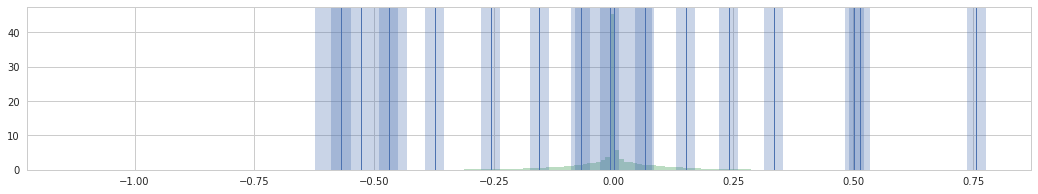

**Epoch: 14**

Layer Loss: -46013.109
Layer Loss: -22.194
Layer Loss: 15633.717
Layer Loss: 30.688
Layer Loss: 2435.803
Layer Loss: 0.317
0-neglogprop Loss: -24948.830
Remaining-neglogprop Loss: -24922.688
Epoch: 14. Loss: 1.4612016677856445. Accuracy: 98.11
Means: [-0.516, -0.569, -0.47, -0.374, -0.257, -0.156, -0.069, -0.008, 0.065, 0.15, 0.24, 0.336, 0.501, 0.499, 0.757]
Mixing Proportions: [3.536, -4.332, -5.348, -5.337, -5.257, -5.164, -5.101, -5.087, -5.126, -5.219, -5.335, -5.39, -5.398, 0.888, -1.25]
Precisions: [5.161, 4.634, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.49, 7.846]


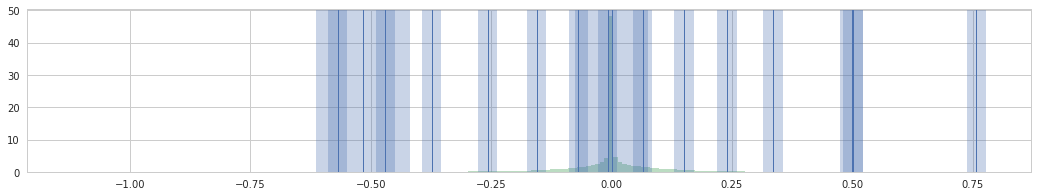

**Epoch: 15**

Layer Loss: -58350.906
Layer Loss: -27.313
Layer Loss: 14918.858
Layer Loss: 27.634
Layer Loss: 2558.075
Layer Loss: 0.132
0-neglogprop Loss: -25452.283
Remaining-neglogprop Loss: -24906.047
Epoch: 15. Loss: 1.4611743688583374. Accuracy: 98.04
Means: [-0.505, -0.569, -0.47, -0.374, -0.257, -0.156, -0.069, -0.008, 0.065, 0.15, 0.24, 0.339, 0.502, 0.485, 0.757]
Mixing Proportions: [3.583, -4.599, -5.613, -5.603, -5.522, -5.43, -5.367, -5.353, -5.391, -5.484, -5.6, -5.655, -5.665, 1.083, -1.262]
Precisions: [5.274, 4.584, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.395, 7.847]


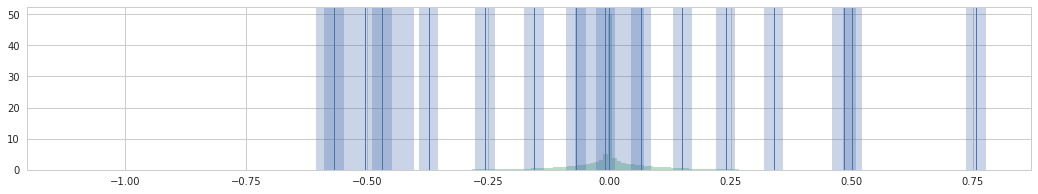

**Epoch: 16**

Layer Loss: -71246.766
Layer Loss: -31.786
Layer Loss: 14131.936
Layer Loss: 24.675
Layer Loss: 2695.442
Layer Loss: 0.003
0-neglogprop Loss: -25975.490
Remaining-neglogprop Loss: -24886.637
Epoch: 16. Loss: 1.4612375497817993. Accuracy: 98.11
Means: [-0.494, -0.569, -0.47, -0.373, -0.257, -0.156, -0.071, -0.008, 0.065, 0.151, 0.24, 0.348, 0.503, 0.454, 0.757]
Mixing Proportions: [3.531, -4.836, -5.849, -5.839, -5.758, -5.666, -5.603, -5.589, -5.627, -5.72, -5.836, -5.89, -5.901, 1.372, -1.344]
Precisions: [5.394, 4.531, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.08, 7.847]


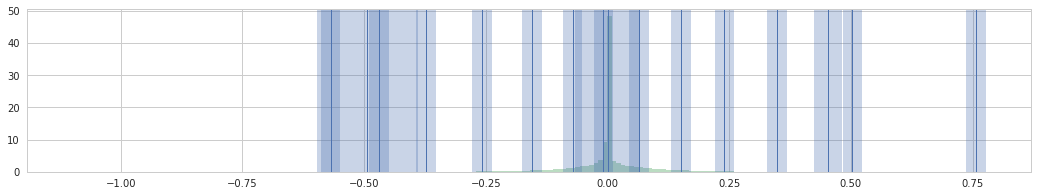

**Epoch: 17**

Layer Loss: -84433.406
Layer Loss: -35.694
Layer Loss: 13373.728
Layer Loss: 22.324
Layer Loss: 2855.695
Layer Loss: -0.046
0-neglogprop Loss: -26523.814
Remaining-neglogprop Loss: -24839.400
Epoch: 17. Loss: 1.471579909324646. Accuracy: 98.04
Means: [-0.482, -0.569, -0.47, -0.373, -0.258, -0.156, -0.072, -0.008, 0.065, 0.151, 0.24, 0.35, 0.506, 0.39, 0.757]
Mixing Proportions: [3.282, -5.099, -6.11, -6.1, -6.02, -5.927, -5.865, -5.851, -5.889, -5.982, -6.097, -6.151, -6.163, 1.918, -1.659]
Precisions: [5.538, 4.474, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 6.204, 7.848]


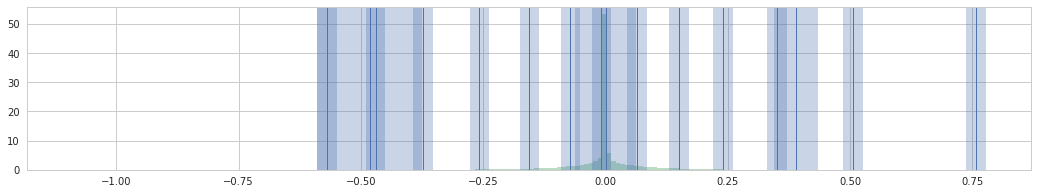

**Epoch: 18**

Layer Loss: -98310.102
Layer Loss: -36.702
Layer Loss: 12667.020
Layer Loss: 21.497
Layer Loss: 3072.975
Layer Loss: 0.027
0-neglogprop Loss: -27175.730
Remaining-neglogprop Loss: -24676.928
Epoch: 18. Loss: 1.4611848592758179. Accuracy: 98.08
Means: [-0.47, -0.569, -0.47, -0.373, -0.258, -0.156, -0.069, -0.008, 0.065, 0.151, 0.24, 0.349, 0.507, 0.368, 0.757]
Mixing Proportions: [3.282, -5.363, -6.372, -6.362, -6.282, -6.19, -6.128, -6.113, -6.151, -6.244, -6.36, -6.413, -6.425, 2.157, -1.723]
Precisions: [5.676, 4.41, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.995, 7.848]


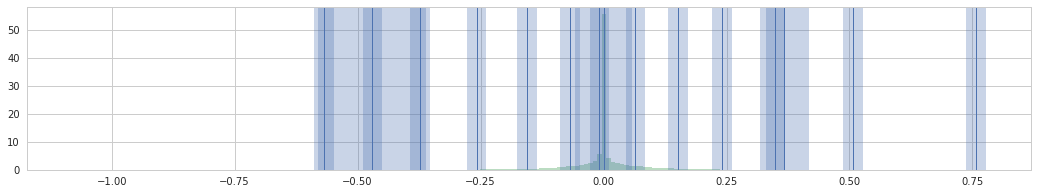

**Epoch: 19**

Layer Loss: -112634.398
Layer Loss: -36.268
Layer Loss: 11868.357
Layer Loss: 19.878
Layer Loss: 3286.476
Layer Loss: 0.051
0-neglogprop Loss: -27791.262
Remaining-neglogprop Loss: -24618.957
Epoch: 19. Loss: 1.4611650705337524. Accuracy: 98.11
Means: [-0.458, -0.569, -0.47, -0.373, -0.258, -0.156, -0.069, -0.008, 0.065, 0.151, 0.24, 0.349, 0.507, 0.351, 0.757]
Mixing Proportions: [3.313, -5.599, -6.607, -6.596, -6.517, -6.425, -6.362, -6.348, -6.386, -6.479, -6.594, -6.648, -6.66, 2.334, -1.747]
Precisions: [5.818, 4.345, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.892, 7.848]


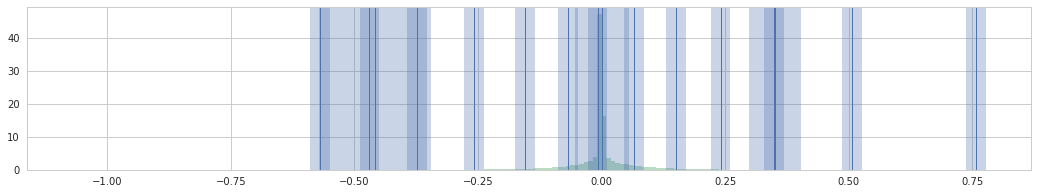

**Epoch: 20**

Layer Loss: -127553.719
Layer Loss: -35.622
Layer Loss: 10988.564
Layer Loss: 18.403
Layer Loss: 3513.947
Layer Loss: 0.168
0-neglogprop Loss: -28410.125
Remaining-neglogprop Loss: -24581.533
Epoch: 20. Loss: 1.4721778631210327. Accuracy: 98.07
Means: [-0.447, -0.569, -0.47, -0.373, -0.258, -0.156, -0.07, -0.008, 0.065, 0.15, 0.241, 0.349, 0.507, 0.337, 0.756]
Mixing Proportions: [3.349, -5.812, -6.818, -6.808, -6.728, -6.637, -6.574, -6.56, -6.598, -6.69, -6.806, -6.859, -6.872, 2.488, -1.763]
Precisions: [5.962, 4.283, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.79, 7.848]


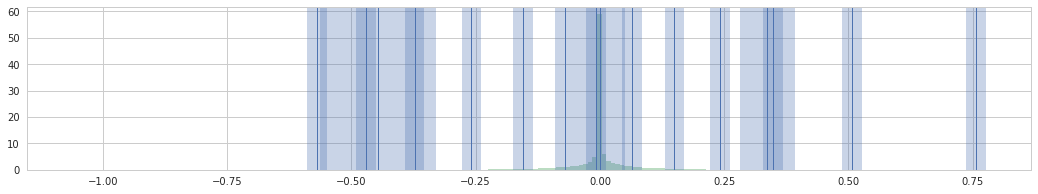

**Epoch: 21**

Layer Loss: -142771.297
Layer Loss: -32.986
Layer Loss: 10091.203
Layer Loss: 17.523
Layer Loss: 3756.978
Layer Loss: 0.374
0-neglogprop Loss: -29026.740
Remaining-neglogprop Loss: -24544.766
Epoch: 21. Loss: 1.46121084690094. Accuracy: 98.06
Means: [-0.436, -0.569, -0.47, -0.373, -0.258, -0.156, -0.068, -0.009, 0.066, 0.15, 0.241, 0.349, 0.507, 0.322, 0.756]
Mixing Proportions: [3.381, -6.008, -7.013, -7.003, -6.923, -6.832, -6.77, -6.756, -6.794, -6.886, -7.0, -7.054, -7.067, 2.632, -1.779]
Precisions: [6.109, 4.225, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.681, 7.847]


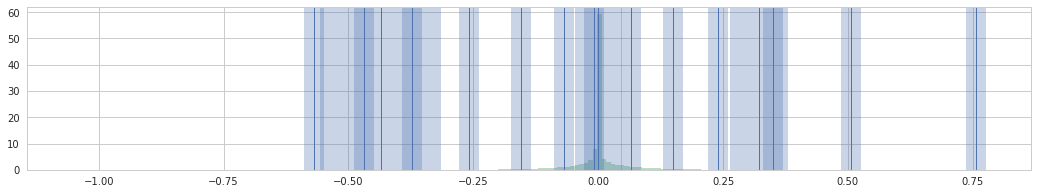

**Epoch: 22**

Layer Loss: -158186.438
Layer Loss: -27.747
Layer Loss: 9182.924
Layer Loss: 17.382
Layer Loss: 4007.925
Layer Loss: 0.681
0-neglogprop Loss: -29638.508
Remaining-neglogprop Loss: -24506.754
Epoch: 22. Loss: 1.4716225862503052. Accuracy: 98.1
Means: [-0.425, -0.569, -0.47, -0.373, -0.258, -0.156, -0.068, -0.009, 0.067, 0.149, 0.241, 0.349, 0.507, 0.308, 0.755]
Mixing Proportions: [3.414, -6.192, -7.195, -7.185, -7.106, -7.014, -6.952, -6.938, -6.976, -7.068, -7.182, -7.236, -7.25, 2.764, -1.793]
Precisions: [6.257, 4.166, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.576, 7.847]


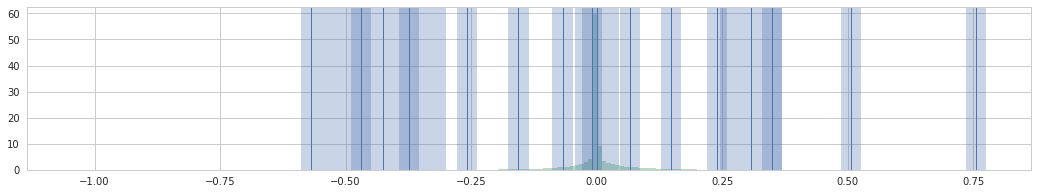

**Epoch: 23**

Layer Loss: -173551.219
Layer Loss: -21.186
Layer Loss: 8322.459
Layer Loss: 18.421
Layer Loss: 4261.045
Layer Loss: 1.140
0-neglogprop Loss: -30234.057
Remaining-neglogprop Loss: -24469.100
Epoch: 23. Loss: 1.4717525243759155. Accuracy: 98.07
Means: [-0.414, -0.569, -0.47, -0.373, -0.258, -0.156, -0.067, -0.006, 0.07, 0.148, 0.241, 0.349, 0.507, 0.295, 0.755]
Mixing Proportions: [3.448, -6.366, -7.367, -7.357, -7.278, -7.187, -7.125, -7.111, -7.149, -7.24, -7.354, -7.408, -7.422, 2.888, -1.807]
Precisions: [6.406, 4.107, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.476, 7.847]


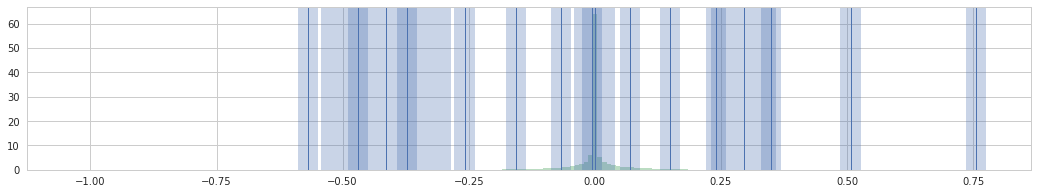

**Epoch: 24**

Layer Loss: -188823.094
Layer Loss: -15.821
Layer Loss: 7474.737
Layer Loss: 20.628
Layer Loss: 4512.515
Layer Loss: 1.731
0-neglogprop Loss: -30810.824
Remaining-neglogprop Loss: -24432.680
Epoch: 24. Loss: 1.4630039930343628. Accuracy: 98.07
Means: [-0.403, -0.569, -0.47, -0.373, -0.258, -0.156, -0.068, -0.006, 0.061, 0.148, 0.241, 0.349, 0.507, 0.282, 0.754]
Mixing Proportions: [3.482, -6.531, -7.531, -7.52, -7.442, -7.351, -7.289, -7.275, -7.313, -7.404, -7.518, -7.571, -7.586, 3.005, -1.817]
Precisions: [6.556, 4.054, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.385, 7.847]


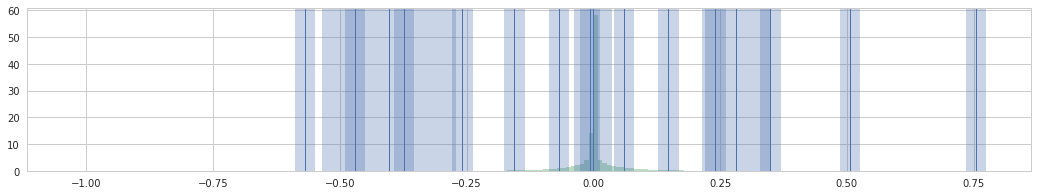

**Epoch: 25**

Layer Loss: -204148.484
Layer Loss: -10.708
Layer Loss: 6623.865
Layer Loss: 24.360
Layer Loss: 4764.000
Layer Loss: 2.573
0-neglogprop Loss: -31367.031
Remaining-neglogprop Loss: -24399.076
Epoch: 25. Loss: 1.4628605842590332. Accuracy: 98.08
Means: [-0.394, -0.569, -0.47, -0.373, -0.258, -0.156, -0.067, -0.007, 0.067, 0.148, 0.241, 0.349, 0.507, 0.27, 0.753]
Mixing Proportions: [3.514, -6.69, -7.687, -7.677, -7.598, -7.507, -7.446, -7.432, -7.47, -7.561, -7.674, -7.727, -7.743, 3.118, -1.826]
Precisions: [6.706, 4.006, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.304, 7.847]


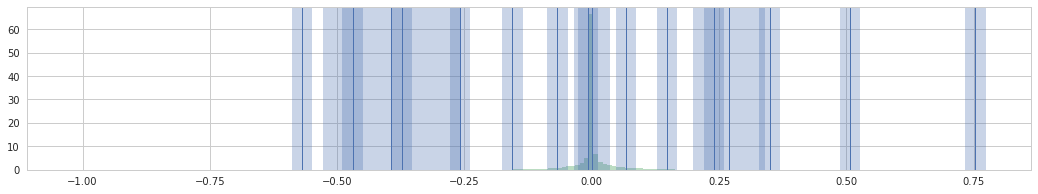

**Epoch: 26**

Layer Loss: -219298.609
Layer Loss: -3.671
Layer Loss: 5788.323
Layer Loss: 29.397
Layer Loss: 5014.544
Layer Loss: 3.573
0-neglogprop Loss: -31888.254
Remaining-neglogprop Loss: -24368.891
Epoch: 26. Loss: 1.4629205465316772. Accuracy: 98.08
Means: [-0.384, -0.569, -0.47, -0.373, -0.258, -0.156, -0.067, -0.004, 0.063, 0.148, 0.241, 0.349, 0.507, 0.258, 0.753]
Mixing Proportions: [3.545, -6.842, -7.837, -7.827, -7.749, -7.658, -7.597, -7.583, -7.621, -7.712, -7.825, -7.878, -7.893, 3.228, -1.835]
Precisions: [6.86, 3.96, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.229, 7.846]


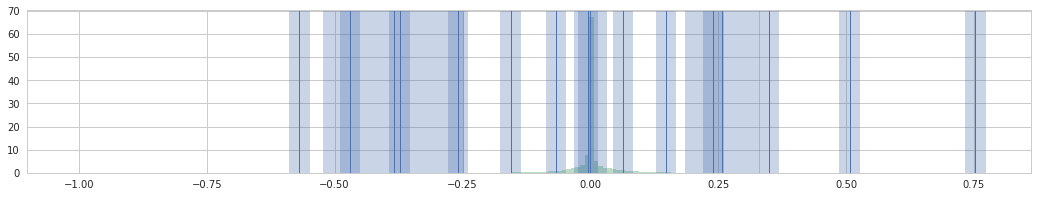

**Epoch: 27**

Layer Loss: -234705.328
Layer Loss: 4.918
Layer Loss: 4924.647
Layer Loss: 34.374
Layer Loss: 5266.030
Layer Loss: 4.712
0-neglogprop Loss: -32387.316
Remaining-neglogprop Loss: -24340.623
Epoch: 27. Loss: 1.4784836769104004. Accuracy: 98.07
Means: [-0.375, -0.569, -0.47, -0.373, -0.258, -0.156, -0.068, -0.002, 0.064, 0.148, 0.241, 0.349, 0.507, 0.247, 0.752]
Mixing Proportions: [3.577, -6.99, -7.983, -7.972, -7.894, -7.804, -7.743, -7.729, -7.767, -7.857, -7.97, -8.023, -8.039, 3.334, -1.841]
Precisions: [7.019, 3.915, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.166, 7.846]


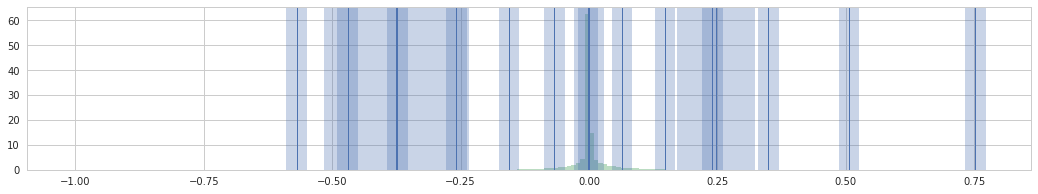

**Epoch: 28**

Layer Loss: -250370.391
Layer Loss: 15.092
Layer Loss: 4023.529
Layer Loss: 41.504
Layer Loss: 5508.295
Layer Loss: 6.304
0-neglogprop Loss: -32851.559
Remaining-neglogprop Loss: -24315.014
Epoch: 28. Loss: 1.4728893041610718. Accuracy: 98.08
Means: [-0.366, -0.569, -0.47, -0.373, -0.258, -0.156, -0.068, -0.005, 0.063, 0.148, 0.241, 0.349, 0.507, 0.237, 0.752]
Mixing Proportions: [3.613, -7.133, -8.123, -8.113, -8.035, -7.945, -7.884, -7.87, -7.908, -7.998, -8.11, -8.163, -8.179, 3.43, -1.843]
Precisions: [7.178, 3.87, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.115, 7.846]


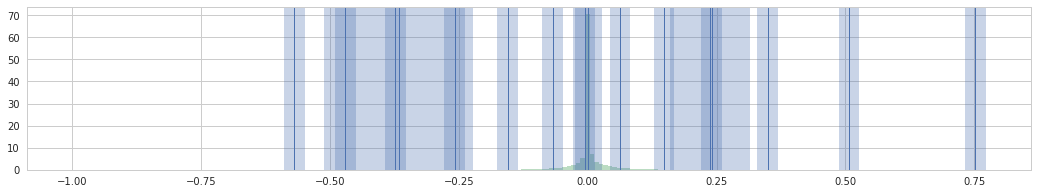

**Epoch: 29**

Layer Loss: -266130.844
Layer Loss: 25.304
Layer Loss: 3043.263
Layer Loss: 48.190
Layer Loss: 5734.835
Layer Loss: 8.060
0-neglogprop Loss: -33261.410
Remaining-neglogprop Loss: -24292.174
Epoch: 29. Loss: 1.4676891565322876. Accuracy: 97.99
Means: [-0.357, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.015, 0.063, 0.148, 0.241, 0.349, 0.507, 0.228, 0.751]
Mixing Proportions: [3.651, -7.272, -8.259, -8.249, -8.171, -8.082, -8.021, -8.007, -8.045, -8.134, -8.246, -8.299, -8.316, 3.522, -1.844]
Precisions: [7.343, 3.823, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.068, 7.845]


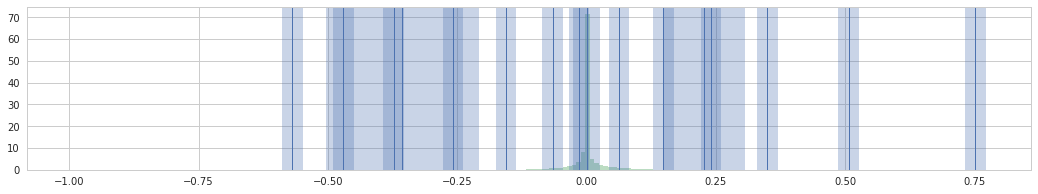

**Epoch: 30**

Layer Loss: -282391.656
Layer Loss: 36.519
Layer Loss: 1956.448
Layer Loss: 56.986
Layer Loss: 5955.702
Layer Loss: 10.161
0-neglogprop Loss: -33616.391
Remaining-neglogprop Loss: -24269.758
Epoch: 30. Loss: 1.4715323448181152. Accuracy: 98.04
Means: [-0.347, -0.569, -0.47, -0.373, -0.258, -0.156, -0.065, -0.014, 0.063, 0.148, 0.241, 0.349, 0.507, 0.219, 0.751]
Mixing Proportions: [3.692, -7.407, -8.39, -8.38, -8.303, -8.214, -8.154, -8.14, -8.177, -8.267, -8.378, -8.43, -8.448, 3.609, -1.842]
Precisions: [7.512, 3.775, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 5.026, 7.844]


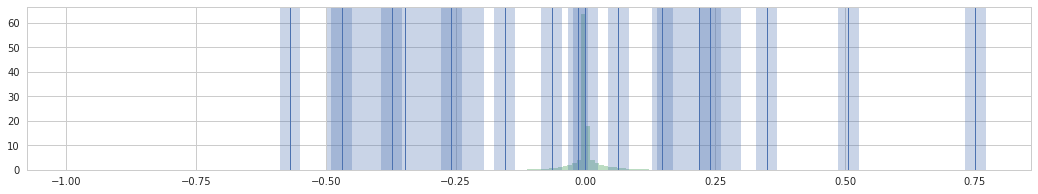

**Epoch: 31**

Layer Loss: -299028.719
Layer Loss: 47.864
Layer Loss: 782.442
Layer Loss: 66.503
Layer Loss: 6165.030
Layer Loss: 12.679
0-neglogprop Loss: -33892.898
Remaining-neglogprop Loss: -24248.250
Epoch: 31. Loss: 1.479682445526123. Accuracy: 98.07
Means: [-0.338, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.015, 0.063, 0.148, 0.241, 0.349, 0.507, 0.211, 0.751]
Mixing Proportions: [3.734, -7.538, -8.518, -8.508, -8.432, -8.343, -8.283, -8.269, -8.306, -8.395, -8.506, -8.557, -8.576, 3.692, -1.837]
Precisions: [7.687, 3.729, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 4.987, 7.844]


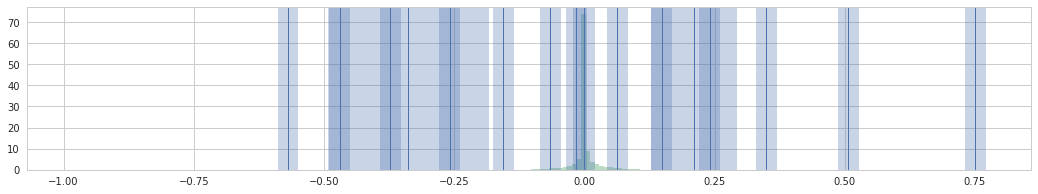

**Epoch: 32**

Layer Loss: -316324.219
Layer Loss: 57.825
Layer Loss: -580.075
Layer Loss: 79.309
Layer Loss: 6361.524
Layer Loss: 15.720
0-neglogprop Loss: -34067.516
Remaining-neglogprop Loss: -24227.654
Epoch: 32. Loss: 1.4646373987197876. Accuracy: 98.01
Means: [-0.329, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.016, 0.063, 0.148, 0.241, 0.349, 0.507, 0.203, 0.75]
Mixing Proportions: [3.777, -7.666, -8.642, -8.632, -8.556, -8.468, -8.408, -8.394, -8.431, -8.52, -8.63, -8.681, -8.701, 3.771, -1.83]
Precisions: [7.868, 3.681, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 4.946, 7.843]


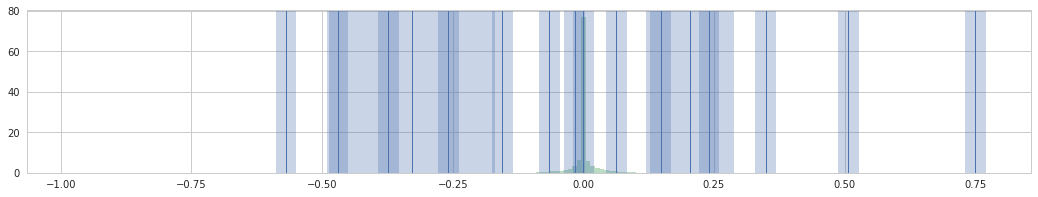

**Epoch: 33**

Layer Loss: -334335.031
Layer Loss: 69.595
Layer Loss: -2152.269
Layer Loss: 92.817
Layer Loss: 6546.922
Layer Loss: 19.044
0-neglogprop Loss: -34107.469
Remaining-neglogprop Loss: -24206.609
Epoch: 33. Loss: 1.4736452102661133. Accuracy: 98.02
Means: [-0.318, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.016, 0.063, 0.148, 0.241, 0.349, 0.507, 0.196, 0.75]
Mixing Proportions: [3.82, -7.791, -8.763, -8.753, -8.677, -8.59, -8.53, -8.516, -8.553, -8.641, -8.75, -8.801, -8.82, 3.849, -1.827]
Precisions: [8.063, 3.626, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 4.9, 7.842]


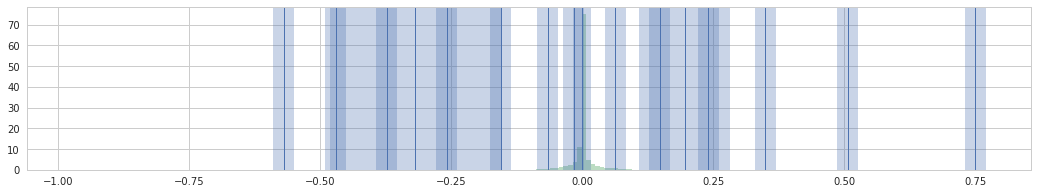

**Epoch: 34**

Layer Loss: -353565.750
Layer Loss: 82.887
Layer Loss: -3925.660
Layer Loss: 105.784
Layer Loss: 6723.952
Layer Loss: 22.849
0-neglogprop Loss: -33957.406
Remaining-neglogprop Loss: -24182.385
Epoch: 34. Loss: 1.4690150022506714. Accuracy: 97.99
Means: [-0.307, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.014, 0.063, 0.148, 0.241, 0.349, 0.507, 0.187, 0.75]
Mixing Proportions: [3.865, -7.914, -8.88, -8.871, -8.796, -8.709, -8.65, -8.636, -8.672, -8.76, -8.868, -8.919, -8.936, 3.924, -1.824]
Precisions: [8.274, 3.566, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 4.845, 7.841]


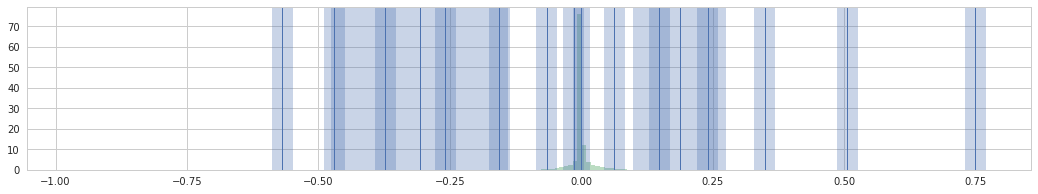

**Epoch: 35**

Layer Loss: -374329.438
Layer Loss: 97.602
Layer Loss: -5985.115
Layer Loss: 121.507
Layer Loss: 6885.640
Layer Loss: 25.362
0-neglogprop Loss: -33521.910
Remaining-neglogprop Loss: -24154.502
Epoch: 35. Loss: 1.467785358428955. Accuracy: 97.96
Means: [-0.295, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.014, 0.063, 0.148, 0.241, 0.349, 0.507, 0.179, 0.749]
Mixing Proportions: [3.912, -8.035, -8.996, -8.986, -8.912, -8.825, -8.767, -8.753, -8.789, -8.876, -8.984, -9.034, -9.053, 3.996, -1.824]
Precisions: [8.504, 3.498, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 4.771, 7.84]


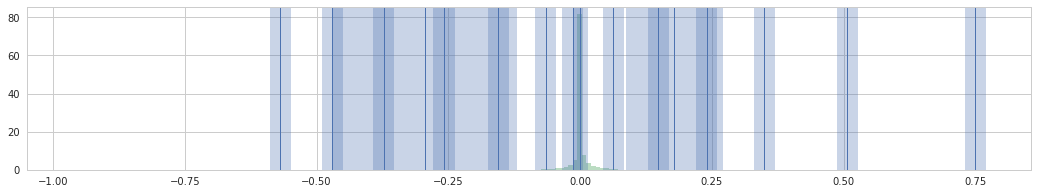

**Epoch: 36**

Layer Loss: -397249.250
Layer Loss: 111.636
Layer Loss: -8430.824
Layer Loss: 134.924
Layer Loss: 7044.280
Layer Loss: 26.953
0-neglogprop Loss: -32641.238
Remaining-neglogprop Loss: -24120.215
Epoch: 36. Loss: 1.4658503532409668. Accuracy: 97.93
Means: [-0.292, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, 0.16, 0.749]
Mixing Proportions: [3.91, -8.154, -9.109, -9.1, -9.026, -8.94, -8.882, -8.869, -8.904, -8.991, -9.097, -9.147, -9.167, 4.119, -1.831]
Precisions: [8.771, 3.493, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 4.546, 7.839]


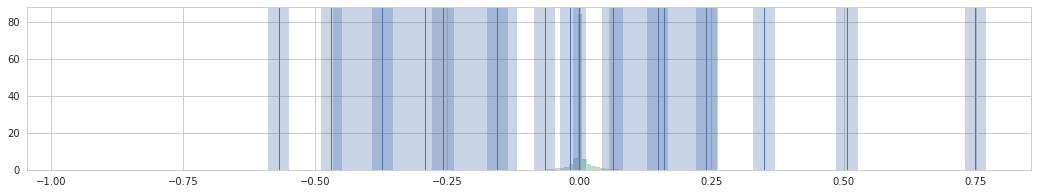

**Epoch: 37**

Layer Loss: -423555.062
Layer Loss: 129.783
Layer Loss: -11419.839
Layer Loss: 149.161
Layer Loss: 7215.232
Layer Loss: 28.586
0-neglogprop Loss: -30959.477
Remaining-neglogprop Loss: -24065.303
Epoch: 37. Loss: 1.4677176475524902. Accuracy: 97.85
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, 0.056, 0.753]
Mixing Proportions: [1.872, -8.218, -9.17, -9.16, -9.087, -9.002, -8.944, -8.93, -8.966, -9.052, -9.158, -9.208, -9.227, 6.548, -3.308]
Precisions: [9.147, 5.647, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.644, 7.82]


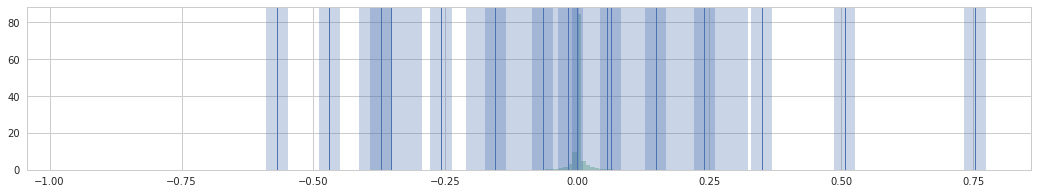

**Epoch: 38**

Layer Loss: -461002.719
Layer Loss: 139.035
Layer Loss: -16578.498
Layer Loss: 166.124
Layer Loss: 7129.973
Layer Loss: 24.735
0-neglogprop Loss: -26954.803
Remaining-neglogprop Loss: -24111.121
Epoch: 38. Loss: 1.4629788398742676. Accuracy: 97.81
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, 0.018, 0.753]
Mixing Proportions: [1.397, -8.237, -9.188, -9.178, -9.105, -9.02, -8.962, -8.949, -8.984, -9.07, -9.176, -9.225, -9.244, 7.023, -3.556]
Precisions: [9.536, 6.978, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.801, 7.82]


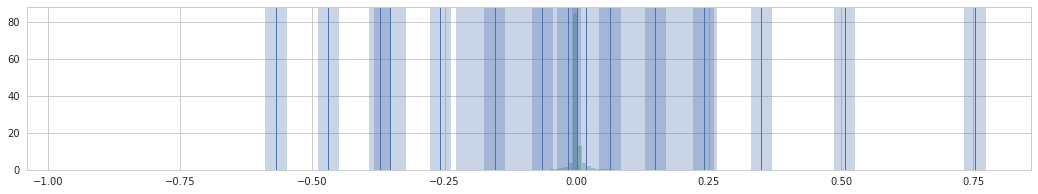

**Epoch: 39**

Layer Loss: -503876.000
Layer Loss: 148.473
Layer Loss: -22512.703
Layer Loss: 175.615
Layer Loss: 7176.541
Layer Loss: 23.445
0-neglogprop Loss: -19963.201
Remaining-neglogprop Loss: -24402.590
Epoch: 39. Loss: 1.4816861152648926. Accuracy: 97.74
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.004, 0.753]
Mixing Proportions: [1.131, -8.252, -9.202, -9.193, -9.119, -9.034, -8.977, -8.963, -8.999, -9.084, -9.19, -9.24, -9.258, 7.289, -3.721]
Precisions: [9.956, 7.591, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.87, 7.82]


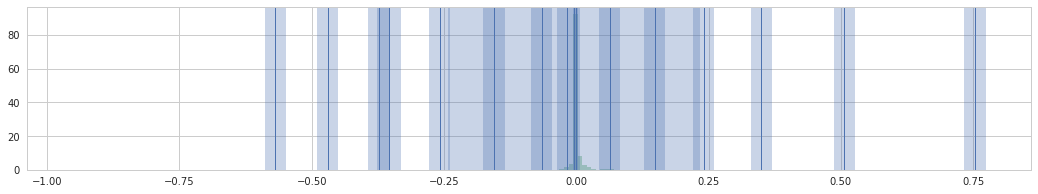

**Epoch: 40**

Layer Loss: -557011.062
Layer Loss: 124.939
Layer Loss: -31059.145
Layer Loss: 170.824
Layer Loss: 7153.318
Layer Loss: 22.142
0-neglogprop Loss: -7618.438
Remaining-neglogprop Loss: -24481.580
Epoch: 40. Loss: 1.4863481521606445. Accuracy: 97.64
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [0.939, -8.266, -9.215, -9.205, -9.132, -9.047, -8.99, -8.976, -9.012, -9.097, -9.203, -9.252, -9.271, 7.482, -3.852]
Precisions: [10.367, 7.779, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.89, 7.82]


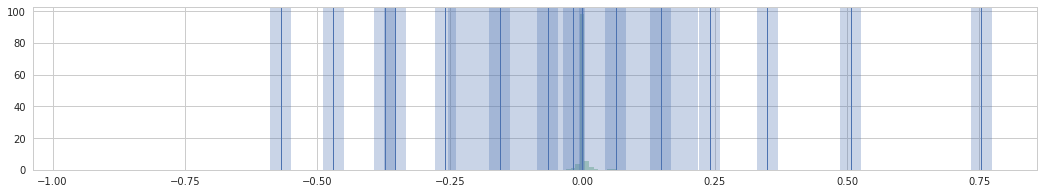

**Epoch: 41**

Layer Loss: -617905.125
Layer Loss: 62.066
Layer Loss: -41701.527
Layer Loss: 140.218
Layer Loss: 7073.650
Layer Loss: 21.038
0-neglogprop Loss: 11782.883
Remaining-neglogprop Loss: -24492.166
Epoch: 41. Loss: 1.4758681058883667. Accuracy: 97.53
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.024, 0.753]
Mixing Proportions: [0.787, -8.279, -9.226, -9.217, -9.144, -9.059, -9.002, -8.988, -9.024, -9.109, -9.214, -9.264, -9.282, 7.635, -3.961]
Precisions: [10.701, 7.815, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.889, 7.82]


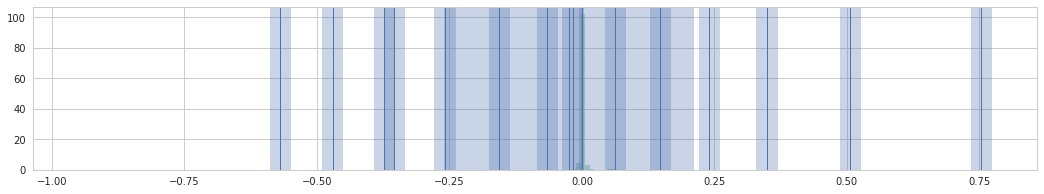

**Epoch: 42**

Layer Loss: -675042.312
Layer Loss: -54.242
Layer Loss: -51702.250
Layer Loss: 83.851
Layer Loss: 6943.841
Layer Loss: 19.519
0-neglogprop Loss: 35291.238
Remaining-neglogprop Loss: -24492.152
Epoch: 42. Loss: 1.4667595624923706. Accuracy: 97.5
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.027, 0.753]
Mixing Proportions: [0.659, -8.291, -9.237, -9.228, -9.155, -9.07, -9.013, -9.0, -9.035, -9.12, -9.225, -9.274, -9.293, 7.764, -4.057]
Precisions: [10.901, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.886, 7.82]


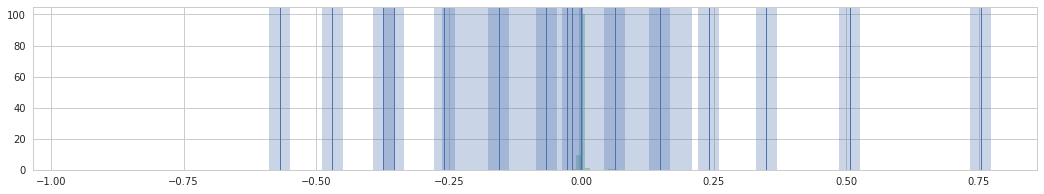

**Epoch: 43**

Layer Loss: -713379.062
Layer Loss: -167.653
Layer Loss: -58123.359
Layer Loss: 24.450
Layer Loss: 6810.014
Layer Loss: 18.734
0-neglogprop Loss: 53953.426
Remaining-neglogprop Loss: -24491.531
Epoch: 43. Loss: 1.4765244722366333. Accuracy: 97.46
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.028, 0.753]
Mixing Proportions: [0.546, -8.303, -9.247, -9.238, -9.165, -9.081, -9.024, -9.01, -9.046, -9.13, -9.236, -9.285, -9.304, 7.877, -4.144]
Precisions: [10.993, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.884, 7.82]


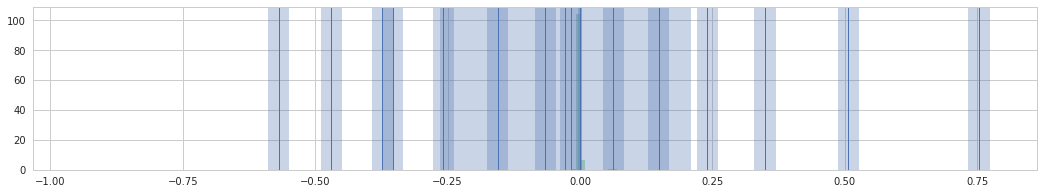

**Epoch: 44**

Layer Loss: -732445.562
Layer Loss: -246.106
Layer Loss: -61120.785
Layer Loss: -12.113
Layer Loss: 6715.542
Layer Loss: 18.030
0-neglogprop Loss: 64001.676
Remaining-neglogprop Loss: -24490.961
Epoch: 44. Loss: 1.4813657999038696. Accuracy: 97.44
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.028, 0.753]
Mixing Proportions: [0.443, -8.315, -9.257, -9.248, -9.175, -9.091, -9.034, -9.021, -9.056, -9.141, -9.246, -9.294, -9.318, 7.98, -4.224]
Precisions: [11.031, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.882, 7.82]


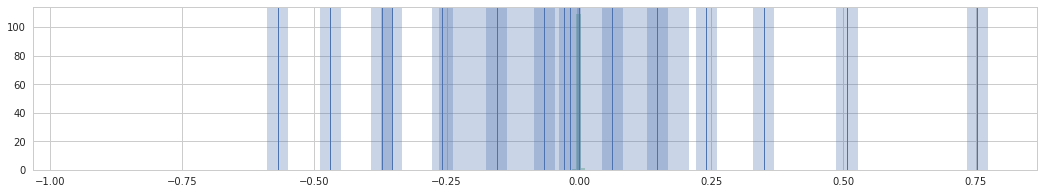

**Epoch: 45**

Layer Loss: -740476.500
Layer Loss: -287.983
Layer Loss: -62336.043
Layer Loss: -29.660
Layer Loss: 6661.334
Layer Loss: 17.643
0-neglogprop Loss: 68391.625
Remaining-neglogprop Loss: -24490.473
Epoch: 45. Loss: 1.4875798225402832. Accuracy: 97.52
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.028, 0.753]
Mixing Proportions: [0.349, -8.326, -9.267, -9.257, -9.185, -9.101, -9.044, -9.031, -9.066, -9.151, -9.255, -9.304, -9.331, 8.074, -4.3]
Precisions: [11.05, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.88, 7.82]


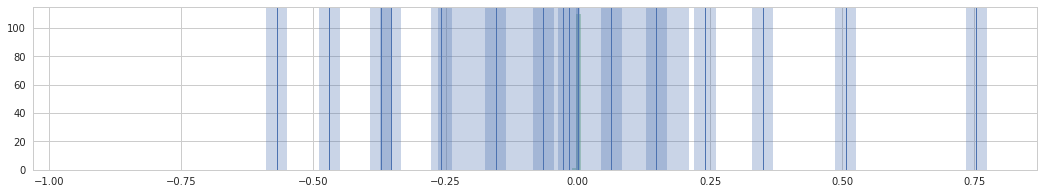

**Epoch: 46**

Layer Loss: -744438.500
Layer Loss: -310.699
Layer Loss: -62917.672
Layer Loss: -39.014
Layer Loss: 6630.688
Layer Loss: 17.268
0-neglogprop Loss: 70594.922
Remaining-neglogprop Loss: -24490.053
Epoch: 46. Loss: 1.4833478927612305. Accuracy: 97.56
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.027, 0.753]
Mixing Proportions: [0.261, -8.338, -9.276, -9.267, -9.195, -9.111, -9.054, -9.041, -9.076, -9.16, -9.265, -9.313, -9.342, 8.163, -4.371]
Precisions: [11.059, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.879, 7.82]


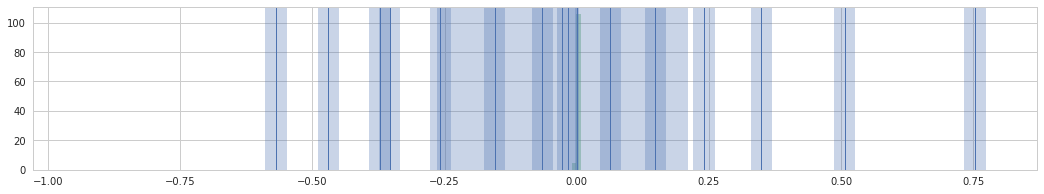

**Epoch: 47**

Layer Loss: -746509.625
Layer Loss: -322.738
Layer Loss: -63206.707
Layer Loss: -43.499
Layer Loss: 6613.792
Layer Loss: 17.213
0-neglogprop Loss: 71734.398
Remaining-neglogprop Loss: -24489.629
Epoch: 47. Loss: 1.4671467542648315. Accuracy: 97.51
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.027, 0.753]
Mixing Proportions: [0.178, -8.349, -9.285, -9.276, -9.204, -9.121, -9.064, -9.051, -9.086, -9.17, -9.274, -9.322, -9.347, 8.246, -4.44]
Precisions: [11.066, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.877, 7.82]


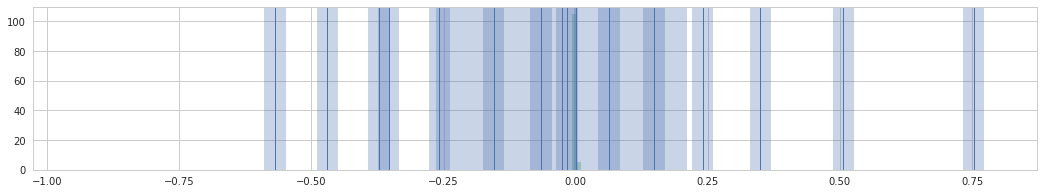

**Epoch: 48**

Layer Loss: -747988.000
Layer Loss: -331.148
Layer Loss: -63419.680
Layer Loss: -46.471
Layer Loss: 6604.656
Layer Loss: 17.079
0-neglogprop Loss: 72541.953
Remaining-neglogprop Loss: -24489.213
Epoch: 48. Loss: 1.474845051765442. Accuracy: 97.54
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.026, 0.753]
Mixing Proportions: [0.099, -8.361, -9.294, -9.285, -9.213, -9.13, -9.074, -9.06, -9.095, -9.179, -9.283, -9.331, -9.341, 8.326, -4.506]
Precisions: [11.07, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.875, 7.82]


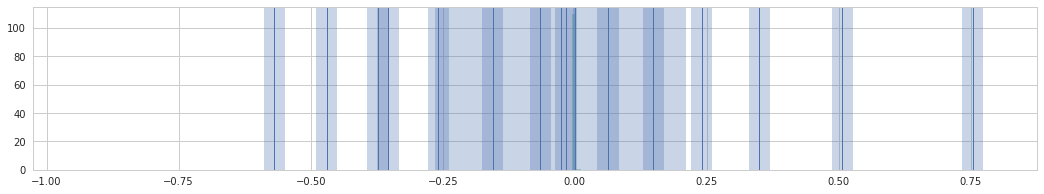

**Epoch: 49**

Layer Loss: -748962.062
Layer Loss: -337.849
Layer Loss: -63561.625
Layer Loss: -48.762
Layer Loss: 6594.021
Layer Loss: 16.989
0-neglogprop Loss: 73081.219
Remaining-neglogprop Loss: -24488.834
Epoch: 49. Loss: 1.4945926666259766. Accuracy: 97.55
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.026, 0.753]
Mixing Proportions: [0.023, -8.372, -9.303, -9.294, -9.222, -9.139, -9.083, -9.07, -9.105, -9.188, -9.291, -9.34, -9.364, 8.403, -4.57]
Precisions: [11.073, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.874, 7.82]


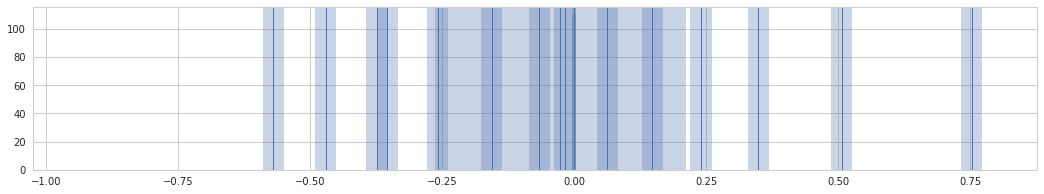

**Epoch: 50**

Layer Loss: -749605.750
Layer Loss: -342.086
Layer Loss: -63665.531
Layer Loss: -50.163
Layer Loss: 6588.251
Layer Loss: 16.851
0-neglogprop Loss: 73426.227
Remaining-neglogprop Loss: -24488.512
Epoch: 50. Loss: 1.4762455224990845. Accuracy: 97.58
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.026, 0.753]
Mixing Proportions: [-0.051, -8.383, -9.312, -9.302, -9.231, -9.148, -9.092, -9.079, -9.114, -9.197, -9.3, -9.348, -9.375, 8.477, -4.633]
Precisions: [11.075, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.873, 7.82]


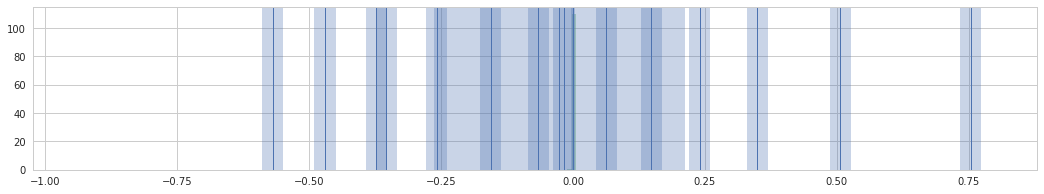

**Epoch: 51**

Layer Loss: -750095.188
Layer Loss: -344.863
Layer Loss: -63735.102
Layer Loss: -50.898
Layer Loss: 6585.692
Layer Loss: 16.906
0-neglogprop Loss: 73684.438
Remaining-neglogprop Loss: -24488.215
Epoch: 51. Loss: 1.4744929075241089. Accuracy: 97.6
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.025, 0.753]
Mixing Proportions: [-0.122, -8.395, -9.32, -9.311, -9.24, -9.157, -9.101, -9.088, -9.123, -9.206, -9.308, -9.356, -9.399, 8.549, -4.694]
Precisions: [11.077, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.872, 7.82]


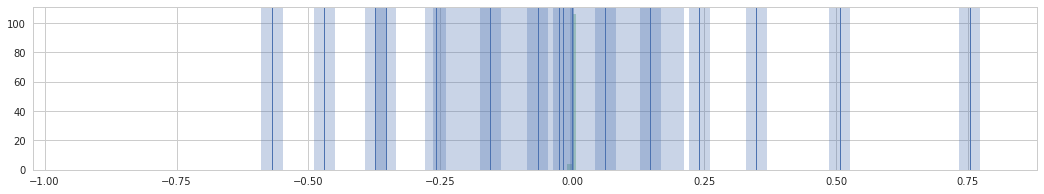

**Epoch: 52**

Layer Loss: -750481.562
Layer Loss: -348.244
Layer Loss: -63801.812
Layer Loss: -52.108
Layer Loss: 6575.668
Layer Loss: 16.791
0-neglogprop Loss: 73924.109
Remaining-neglogprop Loss: -24487.932
Epoch: 52. Loss: 1.4728435277938843. Accuracy: 97.58
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.025, 0.753]
Mixing Proportions: [-0.192, -8.406, -9.328, -9.319, -9.248, -9.166, -9.11, -9.097, -9.132, -9.214, -9.317, -9.364, -9.414, 8.619, -4.754]
Precisions: [11.078, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.871, 7.82]


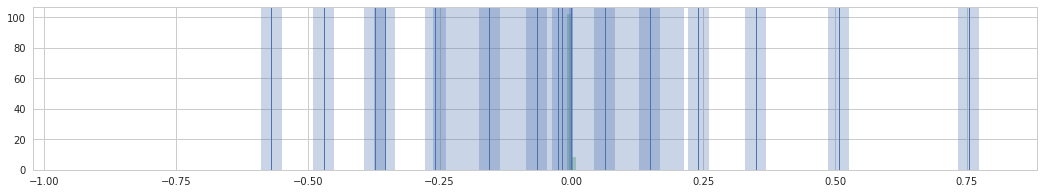

**Epoch: 53**

Layer Loss: -750889.500
Layer Loss: -350.754
Layer Loss: -63852.430
Layer Loss: -52.609
Layer Loss: 6572.121
Layer Loss: 16.837
0-neglogprop Loss: 74137.570
Remaining-neglogprop Loss: -24487.678
Epoch: 53. Loss: 1.4629435539245605. Accuracy: 97.63
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.025, 0.753]
Mixing Proportions: [-0.26, -8.418, -9.336, -9.327, -9.256, -9.175, -9.119, -9.106, -9.141, -9.223, -9.324, -9.372, -9.434, 8.688, -4.813]
Precisions: [11.079, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.87, 7.82]


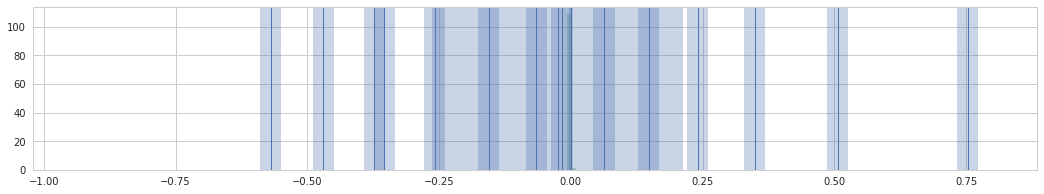

**Epoch: 54**

Layer Loss: -751107.750
Layer Loss: -351.796
Layer Loss: -63898.820
Layer Loss: -53.126
Layer Loss: 6572.333
Layer Loss: 16.791
0-neglogprop Loss: 74256.016
Remaining-neglogprop Loss: -24487.432
Epoch: 54. Loss: 1.485025405883789. Accuracy: 97.65
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.024, 0.753]
Mixing Proportions: [-0.327, -8.429, -9.344, -9.334, -9.264, -9.183, -9.128, -9.115, -9.149, -9.231, -9.332, -9.379, -9.453, 8.755, -4.871]
Precisions: [11.081, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.869, 7.82]


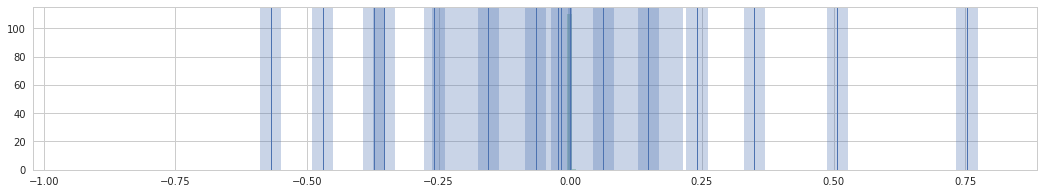

**Epoch: 55**

Layer Loss: -751513.812
Layer Loss: -354.027
Layer Loss: -63965.508
Layer Loss: -53.737
Layer Loss: 6574.007
Layer Loss: 16.719
0-neglogprop Loss: 74472.672
Remaining-neglogprop Loss: -24487.158
Epoch: 55. Loss: 1.5092182159423828. Accuracy: 97.63
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.024, 0.753]
Mixing Proportions: [-0.393, -8.44, -9.351, -9.342, -9.272, -9.191, -9.136, -9.123, -9.157, -9.239, -9.34, -9.387, -9.467, 8.821, -4.928]
Precisions: [11.082, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.867, 7.82]


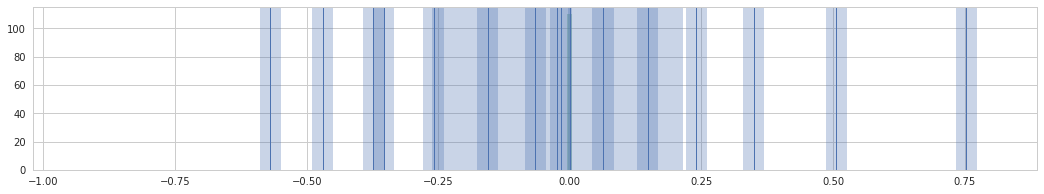

**Epoch: 56**

Layer Loss: -751745.438
Layer Loss: -354.985
Layer Loss: -63991.953
Layer Loss: -54.033
Layer Loss: 6575.163
Layer Loss: 16.719
0-neglogprop Loss: 74556.297
Remaining-neglogprop Loss: -24486.871
Epoch: 56. Loss: 1.4747363328933716. Accuracy: 97.65
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.024, 0.753]
Mixing Proportions: [-0.458, -8.452, -9.358, -9.349, -9.28, -9.199, -9.144, -9.132, -9.166, -9.247, -9.347, -9.394, -9.486, 8.886, -4.985]
Precisions: [11.082, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.866, 7.82]


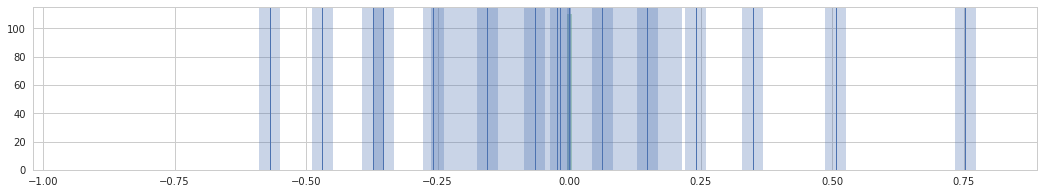

**Epoch: 57**

Layer Loss: -751919.500
Layer Loss: -355.848
Layer Loss: -64014.008
Layer Loss: -54.292
Layer Loss: 6572.536
Layer Loss: 16.767
0-neglogprop Loss: 74642.602
Remaining-neglogprop Loss: -24486.652
Epoch: 57. Loss: 1.4681119918823242. Accuracy: 97.69
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.023, 0.753]
Mixing Proportions: [-0.522, -8.463, -9.365, -9.356, -9.287, -9.207, -9.152, -9.14, -9.173, -9.254, -9.354, -9.401, -9.497, 8.951, -5.041]
Precisions: [11.084, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.865, 7.82]


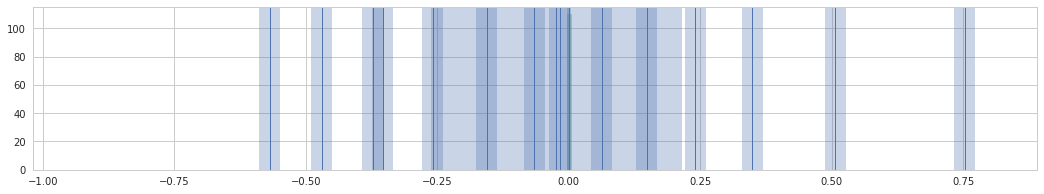

**Epoch: 58**

Layer Loss: -752208.375
Layer Loss: -357.742
Layer Loss: -64064.996
Layer Loss: -54.926
Layer Loss: 6571.113
Layer Loss: 16.698
0-neglogprop Loss: 74789.609
Remaining-neglogprop Loss: -24486.400
Epoch: 58. Loss: 1.4712446928024292. Accuracy: 97.71
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.023, 0.753]
Mixing Proportions: [-0.585, -8.474, -9.372, -9.363, -9.294, -9.214, -9.16, -9.147, -9.181, -9.261, -9.361, -9.407, -9.517, 9.014, -5.096]
Precisions: [11.085, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.865, 7.82]


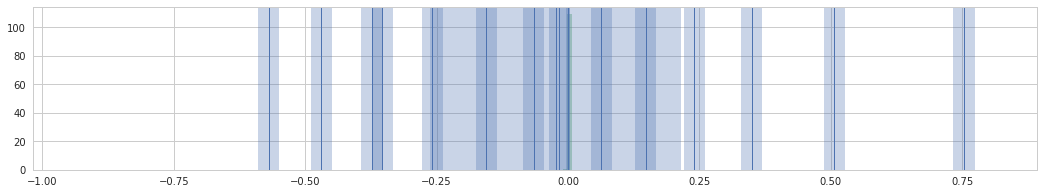

**Epoch: 59**

Layer Loss: -752432.500
Layer Loss: -357.938
Layer Loss: -64083.535
Layer Loss: -54.674
Layer Loss: 6571.308
Layer Loss: 16.704
0-neglogprop Loss: 74900.953
Remaining-neglogprop Loss: -24486.195
Epoch: 59. Loss: 1.4728097915649414. Accuracy: 97.73
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.023, 0.753]
Mixing Proportions: [-0.647, -8.485, -9.379, -9.37, -9.301, -9.222, -9.168, -9.155, -9.188, -9.268, -9.367, -9.414, -9.515, 9.077, -5.15]
Precisions: [11.085, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.864, 7.82]


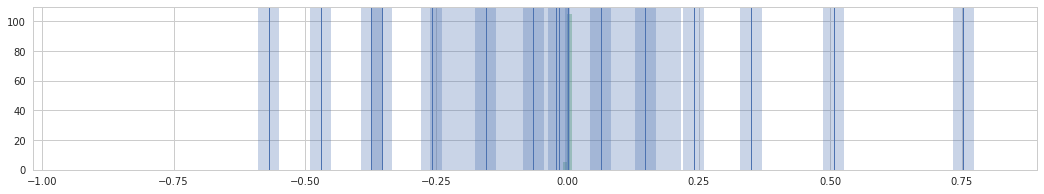

**Epoch: 60**

Layer Loss: -752623.750
Layer Loss: -358.745
Layer Loss: -64102.855
Layer Loss: -54.961
Layer Loss: 6571.940
Layer Loss: 16.733
0-neglogprop Loss: 74976.625
Remaining-neglogprop Loss: -24485.992
Epoch: 60. Loss: 1.4731464385986328. Accuracy: 97.72
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.023, 0.753]
Mixing Proportions: [-0.709, -8.495, -9.385, -9.376, -9.308, -9.229, -9.175, -9.162, -9.195, -9.275, -9.374, -9.42, -9.537, 9.14, -5.204]
Precisions: [11.086, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.863, 7.82]


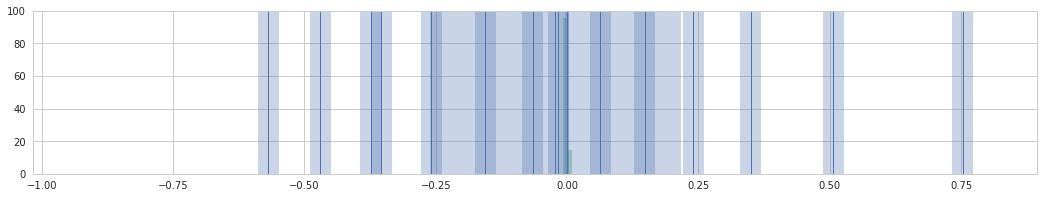

**Epoch: 61**

Layer Loss: -752810.250
Layer Loss: -360.095
Layer Loss: -64142.840
Layer Loss: -55.283
Layer Loss: 6557.684
Layer Loss: 16.712
0-neglogprop Loss: 75085.133
Remaining-neglogprop Loss: -24485.758
Epoch: 61. Loss: 1.480857253074646. Accuracy: 97.74
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.022, 0.753]
Mixing Proportions: [-0.771, -8.506, -9.391, -9.382, -9.314, -9.235, -9.182, -9.169, -9.202, -9.282, -9.38, -9.426, -9.557, 9.202, -5.257]
Precisions: [11.086, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.862, 7.82]


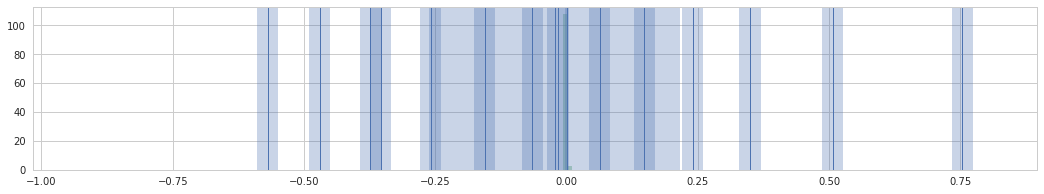

**Epoch: 62**

Layer Loss: -752864.000
Layer Loss: -361.102
Layer Loss: -64153.766
Layer Loss: -55.423
Layer Loss: 6544.963
Layer Loss: 16.720
0-neglogprop Loss: 75080.336
Remaining-neglogprop Loss: -24485.559
Epoch: 62. Loss: 1.475386619567871. Accuracy: 97.78
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.022, 0.753]
Mixing Proportions: [-0.832, -8.516, -9.396, -9.388, -9.32, -9.242, -9.188, -9.176, -9.209, -9.288, -9.386, -9.431, -9.617, 9.264, -5.31]
Precisions: [11.087, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.861, 7.82]


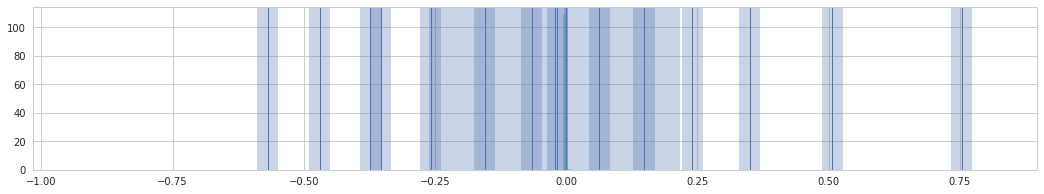

**Epoch: 63**

Layer Loss: -753065.375
Layer Loss: -361.556
Layer Loss: -64175.016
Layer Loss: -55.591
Layer Loss: 6535.824
Layer Loss: 16.701
0-neglogprop Loss: 75189.547
Remaining-neglogprop Loss: -24485.330
Epoch: 63. Loss: 1.472362995147705. Accuracy: 97.77
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.022, 0.753]
Mixing Proportions: [-0.893, -8.526, -9.402, -9.393, -9.326, -9.248, -9.195, -9.183, -9.215, -9.294, -9.391, -9.436, -9.661, 9.325, -5.362]
Precisions: [11.087, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.86, 7.82]


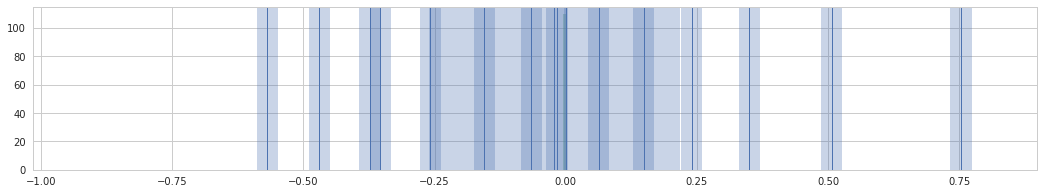

**Epoch: 64**

Layer Loss: -753196.688
Layer Loss: -361.567
Layer Loss: -64186.582
Layer Loss: -55.606
Layer Loss: 6531.297
Layer Loss: 16.715
0-neglogprop Loss: 75210.875
Remaining-neglogprop Loss: -24485.014
Epoch: 64. Loss: 1.474875569343567. Accuracy: 97.72
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.022, 0.753]
Mixing Proportions: [-0.953, -8.536, -9.407, -9.398, -9.331, -9.254, -9.201, -9.189, -9.221, -9.299, -9.396, -9.442, -9.699, 9.386, -5.413]
Precisions: [11.087, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.859, 7.82]


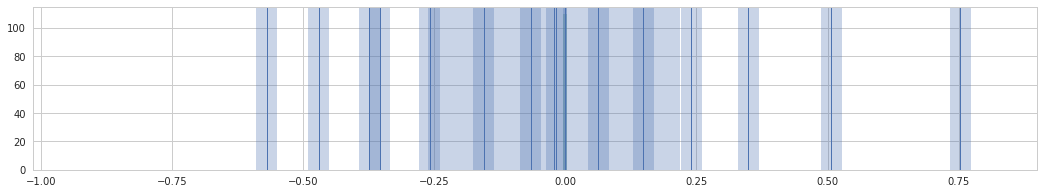

**Epoch: 65**

Layer Loss: -753347.062
Layer Loss: -361.984
Layer Loss: -64214.547
Layer Loss: -55.817
Layer Loss: 6531.091
Layer Loss: 16.695
0-neglogprop Loss: 75261.438
Remaining-neglogprop Loss: -24484.789
Epoch: 65. Loss: 1.4691762924194336. Accuracy: 97.78
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.021, 0.753]
Mixing Proportions: [-1.013, -8.545, -9.412, -9.403, -9.337, -9.259, -9.207, -9.195, -9.227, -9.305, -9.401, -9.446, -9.704, 9.447, -5.464]
Precisions: [11.088, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.858, 7.82]


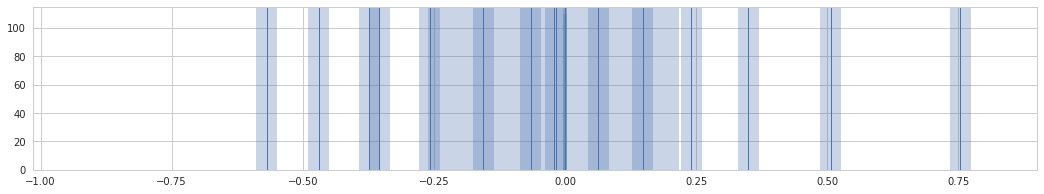

**Epoch: 66**

Layer Loss: -753465.000
Layer Loss: -363.039
Layer Loss: -64222.051
Layer Loss: -55.910
Layer Loss: 6531.946
Layer Loss: 16.672
0-neglogprop Loss: 75300.039
Remaining-neglogprop Loss: -24484.582
Epoch: 66. Loss: 1.4728612899780273. Accuracy: 97.78
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.021, 0.753]
Mixing Proportions: [-1.073, -8.554, -9.417, -9.408, -9.342, -9.265, -9.212, -9.2, -9.233, -9.31, -9.406, -9.451, -9.697, 9.507, -5.514]
Precisions: [11.088, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.857, 7.82]


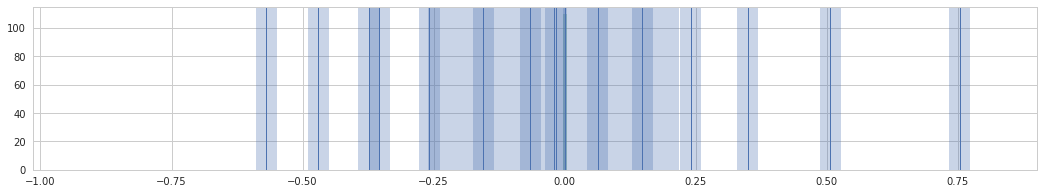

**Epoch: 67**

Layer Loss: -753620.125
Layer Loss: -363.169
Layer Loss: -64238.082
Layer Loss: -56.140
Layer Loss: 6533.849
Layer Loss: 16.670
0-neglogprop Loss: 75371.055
Remaining-neglogprop Loss: -24484.346
Epoch: 67. Loss: 1.4697493314743042. Accuracy: 97.84
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.021, 0.753]
Mixing Proportions: [-1.133, -8.563, -9.421, -9.413, -9.347, -9.27, -9.218, -9.206, -9.238, -9.315, -9.411, -9.455, -9.701, 9.567, -5.563]
Precisions: [11.089, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.856, 7.82]


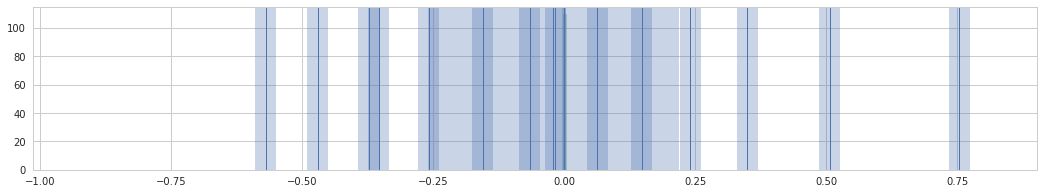

**Epoch: 68**

Layer Loss: -753727.062
Layer Loss: -364.173
Layer Loss: -64261.586
Layer Loss: -56.239
Layer Loss: 6535.908
Layer Loss: 16.678
0-neglogprop Loss: 75406.562
Remaining-neglogprop Loss: -24484.107
Epoch: 68. Loss: 1.4795323610305786. Accuracy: 97.79
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.021, 0.753]
Mixing Proportions: [-1.192, -8.572, -9.426, -9.417, -9.351, -9.275, -9.223, -9.211, -9.243, -9.32, -9.415, -9.46, -9.709, 9.627, -5.611]
Precisions: [11.088, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.855, 7.82]


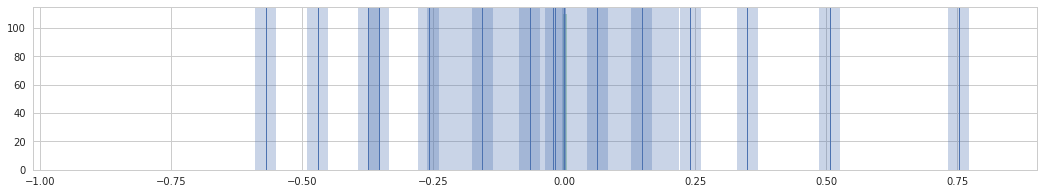

**Epoch: 69**

Layer Loss: -753758.312
Layer Loss: -367.672
Layer Loss: -64278.004
Layer Loss: -56.243
Layer Loss: 6538.327
Layer Loss: 16.674
0-neglogprop Loss: 75389.172
Remaining-neglogprop Loss: -24483.895
Epoch: 69. Loss: 1.483225703239441. Accuracy: 97.83
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.021, 0.753]
Mixing Proportions: [-1.251, -8.58, -9.43, -9.421, -9.356, -9.279, -9.228, -9.216, -9.248, -9.324, -9.419, -9.464, -9.735, 9.687, -5.659]
Precisions: [11.089, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.854, 7.82]


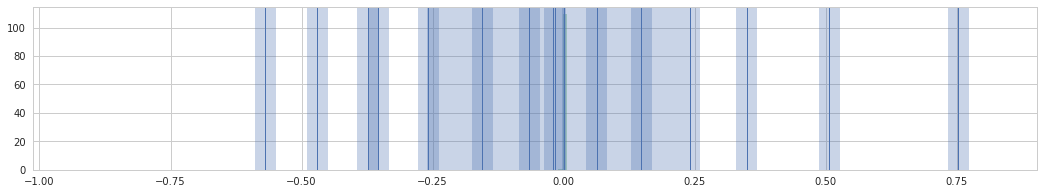

**Epoch: 70**

Layer Loss: -753868.375
Layer Loss: -374.536
Layer Loss: -64285.551
Layer Loss: -56.278
Layer Loss: 6540.867
Layer Loss: 16.691
0-neglogprop Loss: 75422.289
Remaining-neglogprop Loss: -24483.637
Epoch: 70. Loss: 1.4783622026443481. Accuracy: 97.84
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.02, 0.753]
Mixing Proportions: [-1.31, -8.587, -9.434, -9.425, -9.36, -9.284, -9.232, -9.22, -9.252, -9.328, -9.423, -9.467, -9.768, 9.747, -5.705]
Precisions: [11.089, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.853, 7.82]


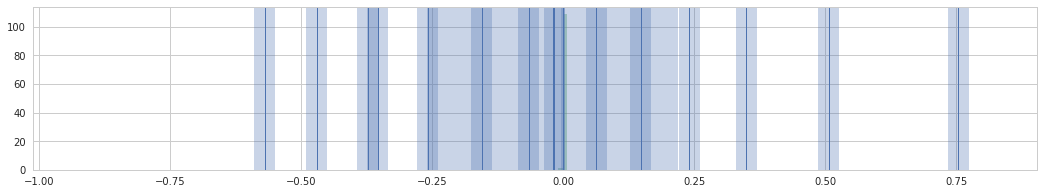

**Epoch: 71**

Layer Loss: -754077.062
Layer Loss: -382.094
Layer Loss: -64304.816
Layer Loss: -56.699
Layer Loss: 6543.212
Layer Loss: 16.678
0-neglogprop Loss: 75508.742
Remaining-neglogprop Loss: -24483.408
Epoch: 71. Loss: 1.4670000076293945. Accuracy: 97.79
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.02, 0.753]
Mixing Proportions: [-1.369, -8.595, -9.437, -9.429, -9.364, -9.288, -9.237, -9.225, -9.257, -9.332, -9.427, -9.471, -9.798, 9.806, -5.751]
Precisions: [11.09, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.852, 7.82]


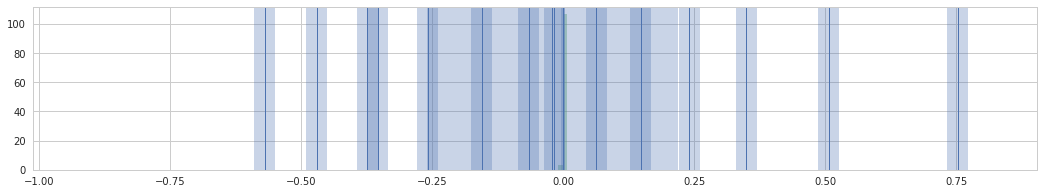

**Epoch: 72**

Layer Loss: -754206.938
Layer Loss: -386.968
Layer Loss: -64310.309
Layer Loss: -56.638
Layer Loss: 6545.402
Layer Loss: 16.676
0-neglogprop Loss: 75567.375
Remaining-neglogprop Loss: -24483.168
Epoch: 72. Loss: 1.476339340209961. Accuracy: 97.79
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.02, 0.753]
Mixing Proportions: [-1.428, -8.602, -9.441, -9.432, -9.367, -9.292, -9.241, -9.229, -9.261, -9.336, -9.43, -9.474, -9.834, 9.866, -5.796]
Precisions: [11.09, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.852, 7.82]


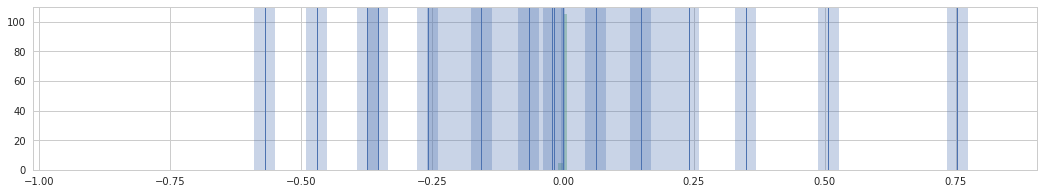

**Epoch: 73**

Layer Loss: -754271.812
Layer Loss: -389.328
Layer Loss: -64320.074
Layer Loss: -56.505
Layer Loss: 6547.741
Layer Loss: 16.697
0-neglogprop Loss: 75594.773
Remaining-neglogprop Loss: -24482.957
Epoch: 73. Loss: 1.4636155366897583. Accuracy: 97.88
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.02, 0.753]
Mixing Proportions: [-1.486, -8.609, -9.444, -9.436, -9.371, -9.296, -9.245, -9.233, -9.264, -9.34, -9.434, -9.477, -9.864, 9.925, -5.839]
Precisions: [11.091, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.85, 7.82]


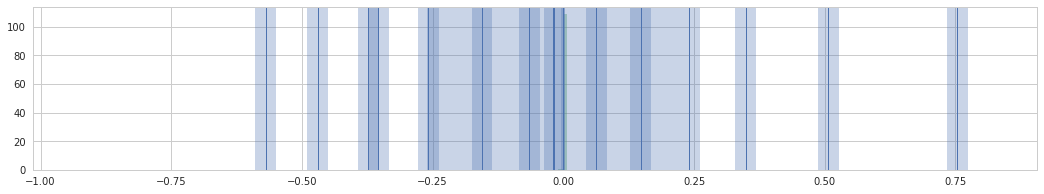

**Epoch: 74**

Layer Loss: -754476.750
Layer Loss: -390.472
Layer Loss: -64336.316
Layer Loss: -56.518
Layer Loss: 6549.681
Layer Loss: 16.695
0-neglogprop Loss: 75675.695
Remaining-neglogprop Loss: -24482.666
Epoch: 74. Loss: 1.471619963645935. Accuracy: 97.83
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.02, 0.753]
Mixing Proportions: [-1.545, -8.615, -9.447, -9.439, -9.374, -9.299, -9.249, -9.237, -9.268, -9.343, -9.437, -9.48, -9.886, 9.985, -5.881]
Precisions: [11.09, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.849, 7.82]


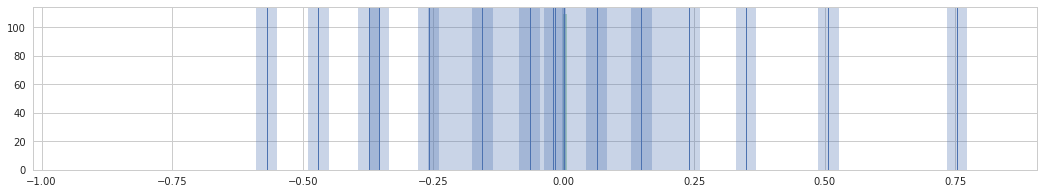

**Epoch: 75**

Layer Loss: -754503.000
Layer Loss: -391.076
Layer Loss: -64328.945
Layer Loss: -56.448
Layer Loss: 6551.510
Layer Loss: 16.712
0-neglogprop Loss: 75628.789
Remaining-neglogprop Loss: -24482.383
Epoch: 75. Loss: 1.4641724824905396. Accuracy: 97.87
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.603, -8.622, -9.45, -9.442, -9.377, -9.303, -9.252, -9.24, -9.272, -9.347, -9.44, -9.483, -9.906, 10.044, -5.923]
Precisions: [11.091, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.848, 7.82]


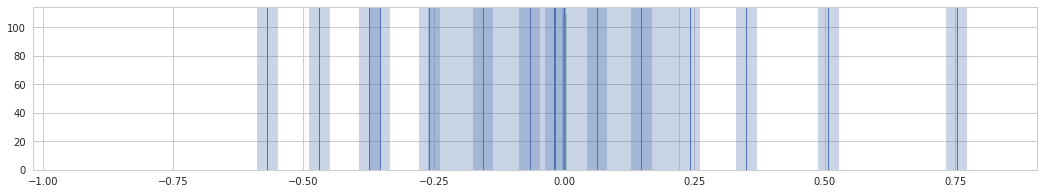

**Epoch: 76**

Layer Loss: -754701.250
Layer Loss: -392.148
Layer Loss: -64365.285
Layer Loss: -56.620
Layer Loss: 6547.889
Layer Loss: 16.711
0-neglogprop Loss: 75722.375
Remaining-neglogprop Loss: -24482.086
Epoch: 76. Loss: 1.4783120155334473. Accuracy: 97.85
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.661, -8.627, -9.453, -9.445, -9.38, -9.306, -9.255, -9.244, -9.275, -9.35, -9.442, -9.486, -9.931, 10.103, -5.963]
Precisions: [11.091, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.847, 7.82]


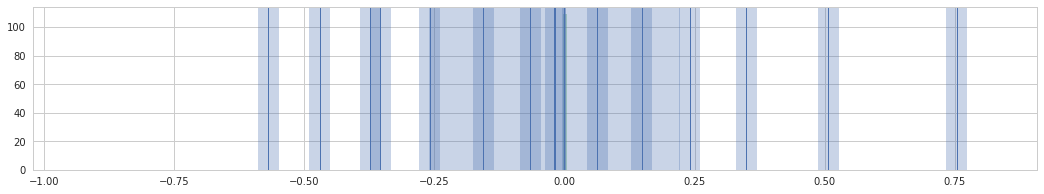

**Epoch: 77**

Layer Loss: -754738.812
Layer Loss: -392.328
Layer Loss: -64368.453
Layer Loss: -56.568
Layer Loss: 6546.412
Layer Loss: 16.697
0-neglogprop Loss: 75704.812
Remaining-neglogprop Loss: -24481.814
Epoch: 77. Loss: 1.4843616485595703. Accuracy: 97.87
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.719, -8.633, -9.456, -9.447, -9.383, -9.309, -9.259, -9.247, -9.278, -9.353, -9.445, -9.488, -9.949, 10.162, -6.001]
Precisions: [11.091, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.846, 7.82]


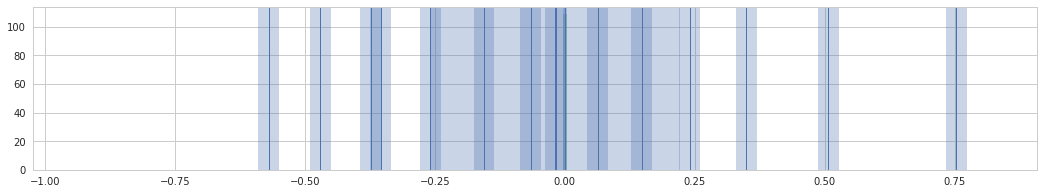

**Epoch: 78**

Layer Loss: -754832.812
Layer Loss: -393.177
Layer Loss: -64369.641
Layer Loss: -56.690
Layer Loss: 6547.278
Layer Loss: 16.698
0-neglogprop Loss: 75707.578
Remaining-neglogprop Loss: -24481.527
Epoch: 78. Loss: 1.4840277433395386. Accuracy: 97.85
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.777, -8.638, -9.458, -9.45, -9.386, -9.312, -9.262, -9.25, -9.281, -9.355, -9.448, -9.491, -10.001, 10.221, -6.039]
Precisions: [11.091, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.845, 7.82]


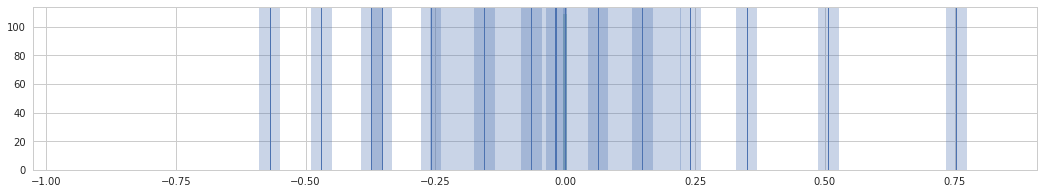

**Epoch: 79**

Layer Loss: -754868.812
Layer Loss: -399.170
Layer Loss: -64379.914
Layer Loss: -56.777
Layer Loss: 6548.237
Layer Loss: 16.708
0-neglogprop Loss: 75710.461
Remaining-neglogprop Loss: -24481.230
Epoch: 79. Loss: 1.4896225929260254. Accuracy: 97.88
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.835, -8.643, -9.46, -9.452, -9.388, -9.314, -9.264, -9.253, -9.284, -9.358, -9.45, -9.493, -10.025, 10.28, -6.075]
Precisions: [11.092, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.843, 7.82]


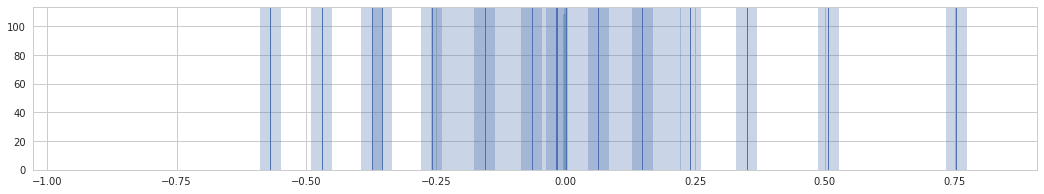

**Epoch: 80**

Layer Loss: -755076.562
Layer Loss: -403.359
Layer Loss: -64392.086
Layer Loss: -56.748
Layer Loss: 6549.836
Layer Loss: 16.714
0-neglogprop Loss: 75785.922
Remaining-neglogprop Loss: -24480.924
Epoch: 80. Loss: 1.4639911651611328. Accuracy: 97.87
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.893, -8.648, -9.463, -9.454, -9.391, -9.317, -9.267, -9.256, -9.286, -9.36, -9.452, -9.495, -10.063, 10.339, -6.11]
Precisions: [11.091, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.842, 7.82]


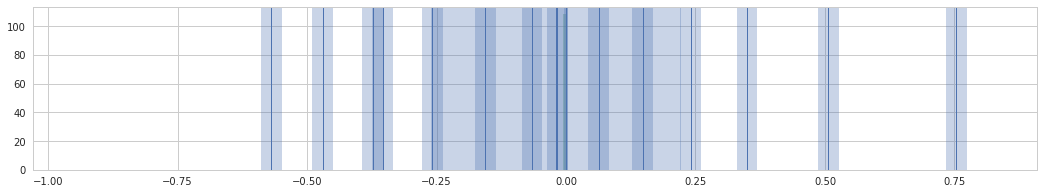

**Epoch: 81**

Layer Loss: -755113.312
Layer Loss: -404.585
Layer Loss: -64381.297
Layer Loss: -56.446
Layer Loss: 6551.621
Layer Loss: 16.718
0-neglogprop Loss: 75753.172
Remaining-neglogprop Loss: -24480.629
Epoch: 81. Loss: 1.4736136198043823. Accuracy: 97.88
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.019, 0.753]
Mixing Proportions: [-1.95, -8.652, -9.465, -9.456, -9.393, -9.319, -9.27, -9.258, -9.289, -9.362, -9.454, -9.497, -10.095, 10.398, -6.143]
Precisions: [11.092, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.841, 7.82]


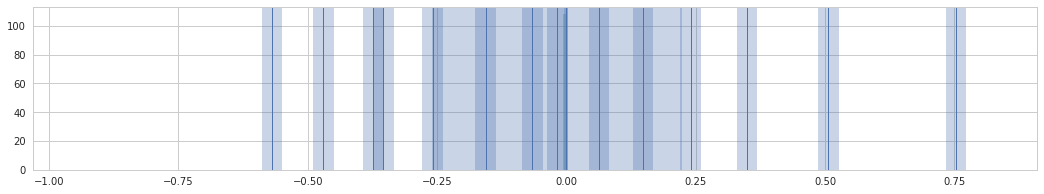

**Epoch: 82**

Layer Loss: -755207.688
Layer Loss: -405.590
Layer Loss: -64397.812
Layer Loss: -56.761
Layer Loss: 6553.617
Layer Loss: 16.707
0-neglogprop Loss: 75779.781
Remaining-neglogprop Loss: -24480.365
Epoch: 82. Loss: 1.4754271507263184. Accuracy: 97.87
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.008, -8.657, -9.467, -9.458, -9.395, -9.322, -9.272, -9.26, -9.291, -9.365, -9.456, -9.499, -10.116, 10.457, -6.175]
Precisions: [11.092, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.84, 7.82]


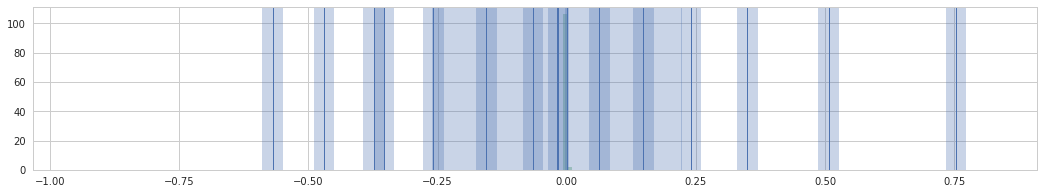

**Epoch: 83**

Layer Loss: -755302.500
Layer Loss: -406.094
Layer Loss: -64411.832
Layer Loss: -56.630
Layer Loss: 6555.681
Layer Loss: 16.721
0-neglogprop Loss: 75791.453
Remaining-neglogprop Loss: -24480.055
Epoch: 83. Loss: 1.4637881517410278. Accuracy: 97.86
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.065, -8.661, -9.468, -9.46, -9.397, -9.324, -9.274, -9.263, -9.293, -9.367, -9.458, -9.501, -10.127, 10.516, -6.206]
Precisions: [11.092, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.839, 7.82]


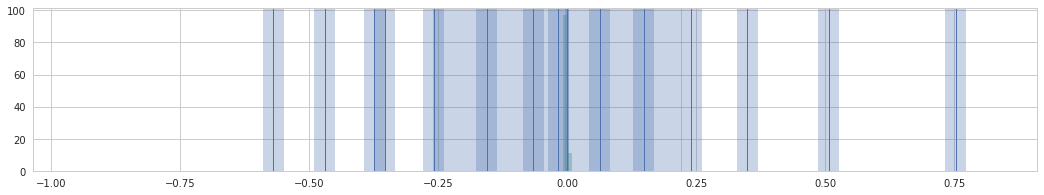

**Epoch: 84**

Layer Loss: -755391.375
Layer Loss: -406.040
Layer Loss: -64411.891
Layer Loss: -56.457
Layer Loss: 6557.945
Layer Loss: 16.748
0-neglogprop Loss: 75811.078
Remaining-neglogprop Loss: -24479.762
Epoch: 84. Loss: 1.4730710983276367. Accuracy: 97.87
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.123, -8.664, -9.47, -9.462, -9.399, -9.326, -9.276, -9.265, -9.295, -9.369, -9.46, -9.503, -10.147, 10.575, -6.235]
Precisions: [11.092, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.837, 7.82]


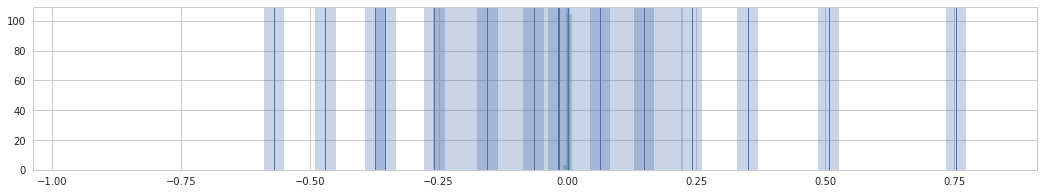

**Epoch: 85**

Layer Loss: -755512.188
Layer Loss: -406.449
Layer Loss: -64433.613
Layer Loss: -56.592
Layer Loss: 6559.984
Layer Loss: 16.747
0-neglogprop Loss: 75858.047
Remaining-neglogprop Loss: -24479.465
Epoch: 85. Loss: 1.4785746335983276. Accuracy: 97.92
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.18, -8.668, -9.472, -9.464, -9.401, -9.328, -9.278, -9.267, -9.297, -9.37, -9.462, -9.504, -10.157, 10.633, -6.263]
Precisions: [11.092, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.836, 7.82]


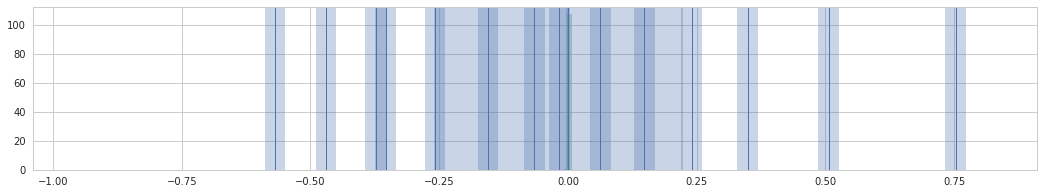

**Epoch: 86**

Layer Loss: -755633.250
Layer Loss: -406.591
Layer Loss: -64446.230
Layer Loss: -56.681
Layer Loss: 6561.702
Layer Loss: 16.725
0-neglogprop Loss: 75882.750
Remaining-neglogprop Loss: -24479.119
Epoch: 86. Loss: 1.4654871225357056. Accuracy: 97.94
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.237, -8.671, -9.473, -9.465, -9.402, -9.329, -9.28, -9.269, -9.299, -9.372, -9.463, -9.506, -10.143, 10.691, -6.29]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.835, 7.82]


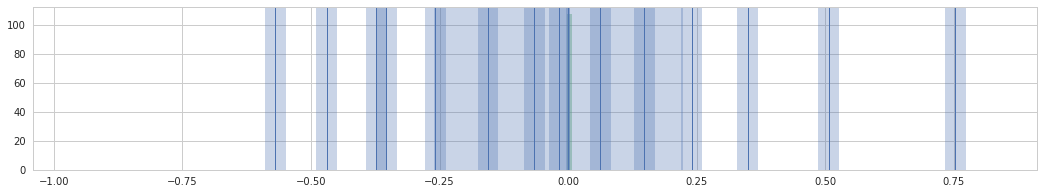

**Epoch: 87**

Layer Loss: -755722.875
Layer Loss: -406.801
Layer Loss: -64455.484
Layer Loss: -56.822
Layer Loss: 6563.588
Layer Loss: 16.711
0-neglogprop Loss: 75911.664
Remaining-neglogprop Loss: -24478.828
Epoch: 87. Loss: 1.496313452720642. Accuracy: 97.92
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.294, -8.675, -9.475, -9.467, -9.404, -9.331, -9.282, -9.27, -9.301, -9.374, -9.465, -9.507, -10.11, 10.748, -6.315]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.833, 7.82]


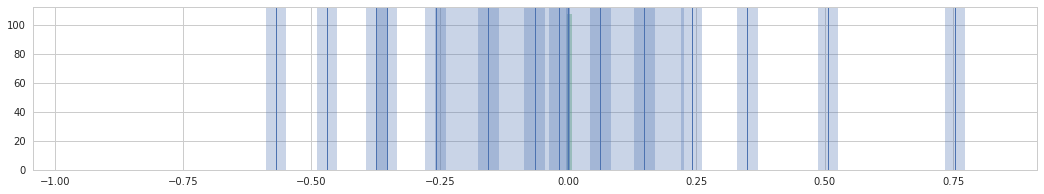

**Epoch: 88**

Layer Loss: -755831.188
Layer Loss: -406.788
Layer Loss: -64465.719
Layer Loss: -56.734
Layer Loss: 6565.541
Layer Loss: 16.725
0-neglogprop Loss: 75912.508
Remaining-neglogprop Loss: -24478.455
Epoch: 88. Loss: 1.469229817390442. Accuracy: 97.98
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.018, 0.753]
Mixing Proportions: [-2.351, -8.678, -9.476, -9.468, -9.405, -9.333, -9.284, -9.272, -9.302, -9.375, -9.466, -9.508, -10.081, 10.805, -6.339]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.832, 7.82]


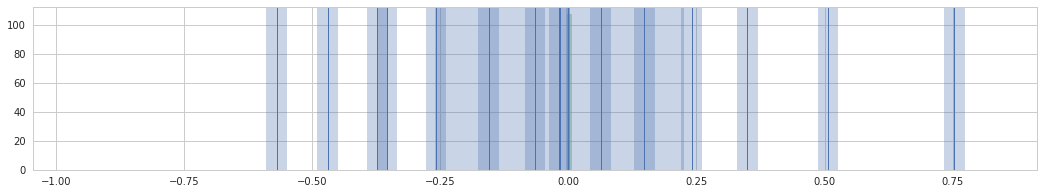

**Epoch: 89**

Layer Loss: -755885.625
Layer Loss: -406.856
Layer Loss: -64475.918
Layer Loss: -56.579
Layer Loss: 6565.660
Layer Loss: 16.750
0-neglogprop Loss: 75922.383
Remaining-neglogprop Loss: -24478.172
Epoch: 89. Loss: 1.4698554277420044. Accuracy: 97.89
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.408, -8.68, -9.478, -9.469, -9.407, -9.334, -9.285, -9.274, -9.304, -9.377, -9.467, -9.51, -10.067, 10.863, -6.362]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.831, 7.82]


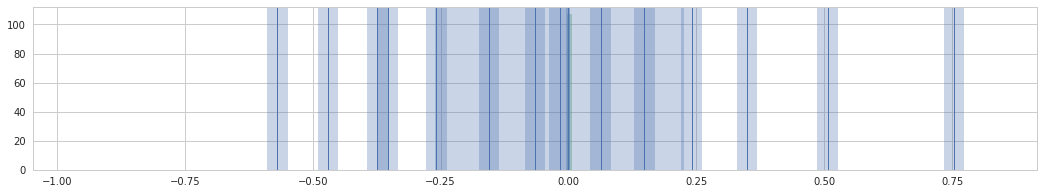

**Epoch: 90**

Layer Loss: -756056.938
Layer Loss: -407.064
Layer Loss: -64490.824
Layer Loss: -56.780
Layer Loss: 6556.049
Layer Loss: 16.722
0-neglogprop Loss: 75989.062
Remaining-neglogprop Loss: -24477.846
Epoch: 90. Loss: 1.4728827476501465. Accuracy: 97.92
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.464, -8.683, -9.479, -9.471, -9.408, -9.336, -9.287, -9.275, -9.305, -9.378, -9.469, -9.511, -10.053, 10.92, -6.383]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.829, 7.82]


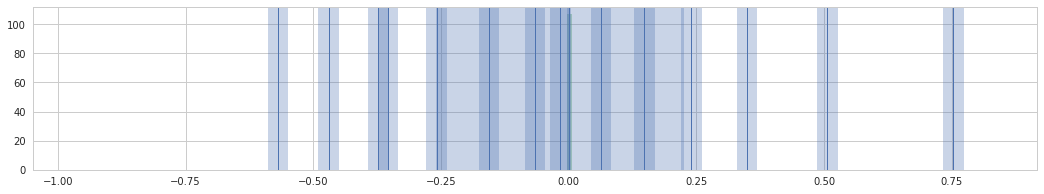

**Epoch: 91**

Layer Loss: -756144.125
Layer Loss: -407.011
Layer Loss: -64496.777
Layer Loss: -56.738
Layer Loss: 6557.957
Layer Loss: 16.732
0-neglogprop Loss: 76004.375
Remaining-neglogprop Loss: -24477.424
Epoch: 91. Loss: 1.4852532148361206. Accuracy: 97.94
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.521, -8.686, -9.48, -9.472, -9.409, -9.337, -9.288, -9.277, -9.307, -9.379, -9.47, -9.512, -10.037, 10.978, -6.404]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.828, 7.82]


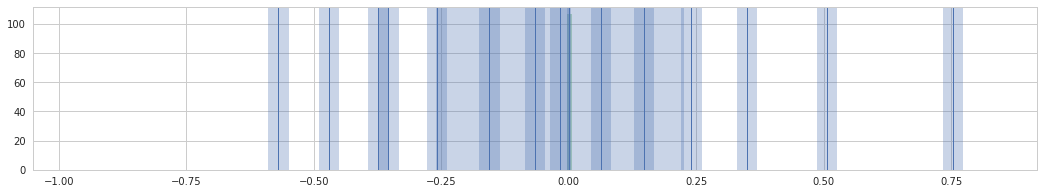

**Epoch: 92**

Layer Loss: -756224.000
Layer Loss: -407.173
Layer Loss: -64506.172
Layer Loss: -56.894
Layer Loss: 6546.607
Layer Loss: 16.721
0-neglogprop Loss: 75989.672
Remaining-neglogprop Loss: -24477.098
Epoch: 92. Loss: 1.4747638702392578. Accuracy: 97.9
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.577, -8.688, -9.481, -9.473, -9.41, -9.338, -9.289, -9.278, -9.308, -9.381, -9.471, -9.513, -10.02, 11.035, -6.423]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.827, 7.82]


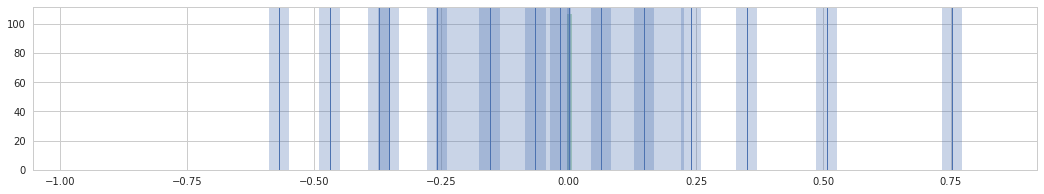

**Epoch: 93**

Layer Loss: -756232.625
Layer Loss: -407.169
Layer Loss: -64524.793
Layer Loss: -56.797
Layer Loss: 6535.415
Layer Loss: 16.724
0-neglogprop Loss: 75982.312
Remaining-neglogprop Loss: -24476.775
Epoch: 93. Loss: 1.4647690057754517. Accuracy: 97.95
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.633, -8.69, -9.482, -9.474, -9.411, -9.339, -9.291, -9.279, -9.309, -9.382, -9.472, -9.514, -9.999, 11.091, -6.442]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.825, 7.82]


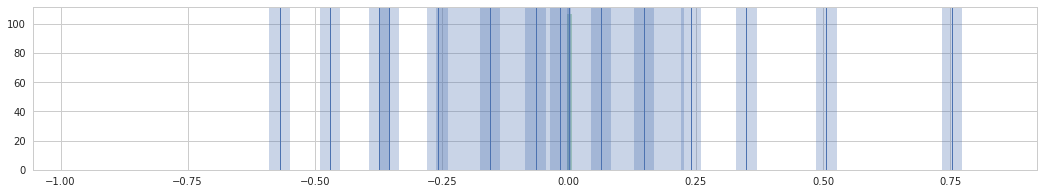

**Epoch: 94**

Layer Loss: -756354.938
Layer Loss: -407.271
Layer Loss: -64536.562
Layer Loss: -56.875
Layer Loss: 6537.190
Layer Loss: 16.729
0-neglogprop Loss: 75965.312
Remaining-neglogprop Loss: -24476.469
Epoch: 94. Loss: 1.463351845741272. Accuracy: 97.96
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.689, -8.692, -9.483, -9.475, -9.413, -9.34, -9.292, -9.28, -9.31, -9.383, -9.473, -9.515, -9.987, 11.148, -6.459]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.824, 7.82]


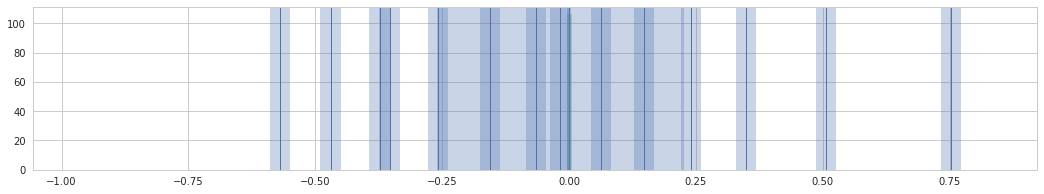

**Epoch: 95**

Layer Loss: -756477.562
Layer Loss: -406.938
Layer Loss: -64551.473
Layer Loss: -56.641
Layer Loss: 6539.040
Layer Loss: 16.748
0-neglogprop Loss: 76017.766
Remaining-neglogprop Loss: -24476.041
Epoch: 95. Loss: 1.4626930952072144. Accuracy: 97.95
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.745, -8.694, -9.484, -9.476, -9.414, -9.342, -9.293, -9.282, -9.312, -9.384, -9.474, -9.516, -9.973, 11.204, -6.475]
Precisions: [11.094, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.823, 7.82]


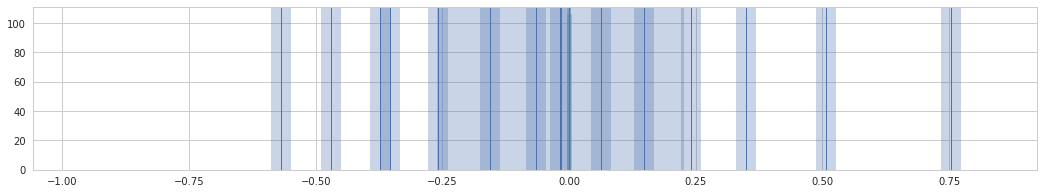

**Epoch: 96**

Layer Loss: -756540.250
Layer Loss: -407.157
Layer Loss: -64563.738
Layer Loss: -56.670
Layer Loss: 6540.904
Layer Loss: 16.739
0-neglogprop Loss: 76029.578
Remaining-neglogprop Loss: -24475.773
Epoch: 96. Loss: 1.4615483283996582. Accuracy: 97.93
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.8, -8.696, -9.485, -9.477, -9.414, -9.343, -9.294, -9.283, -9.313, -9.385, -9.475, -9.517, -9.961, 11.261, -6.491]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.821, 7.82]


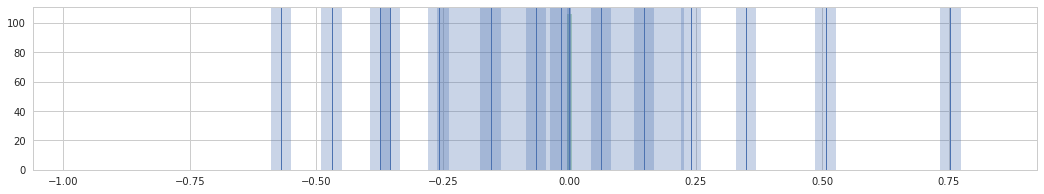

**Epoch: 97**

Layer Loss: -756618.312
Layer Loss: -407.295
Layer Loss: -64578.355
Layer Loss: -56.726
Layer Loss: 6542.439
Layer Loss: 16.738
0-neglogprop Loss: 76017.164
Remaining-neglogprop Loss: -24475.348
Epoch: 97. Loss: 1.4704251289367676. Accuracy: 97.94
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.856, -8.698, -9.486, -9.478, -9.415, -9.343, -9.295, -9.284, -9.314, -9.386, -9.476, -9.518, -9.952, 11.317, -6.505]
Precisions: [11.093, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.819, 7.82]


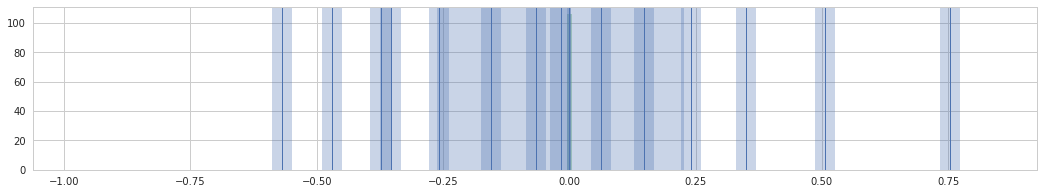

**Epoch: 98**

Layer Loss: -756699.875
Layer Loss: -407.343
Layer Loss: -64580.906
Layer Loss: -56.734
Layer Loss: 6525.764
Layer Loss: 16.750
0-neglogprop Loss: 76011.984
Remaining-neglogprop Loss: -24474.914
Epoch: 98. Loss: 1.4865645170211792. Accuracy: 97.98
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.911, -8.7, -9.486, -9.478, -9.416, -9.344, -9.296, -9.285, -9.315, -9.387, -9.476, -9.518, -9.941, 11.373, -6.519]
Precisions: [11.094, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.818, 7.82]


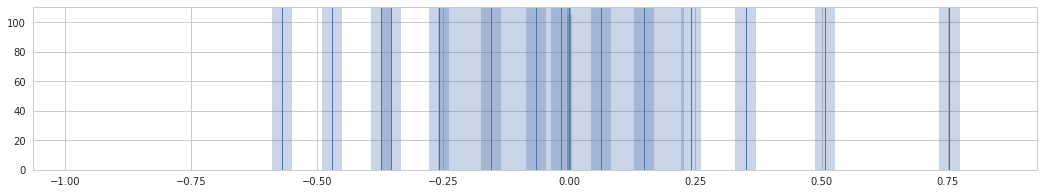

**Epoch: 99**

Layer Loss: -756800.250
Layer Loss: -407.134
Layer Loss: -64624.836
Layer Loss: -56.636
Layer Loss: 6510.005
Layer Loss: 16.764
0-neglogprop Loss: 76060.234
Remaining-neglogprop Loss: -24474.619
Epoch: 99. Loss: 1.4685946702957153. Accuracy: 97.99
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.017, 0.753]
Mixing Proportions: [-2.965, -8.701, -9.487, -9.479, -9.417, -9.345, -9.297, -9.286, -9.315, -9.387, -9.477, -9.519, -9.939, 11.43, -6.532]
Precisions: [11.094, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.816, 7.82]


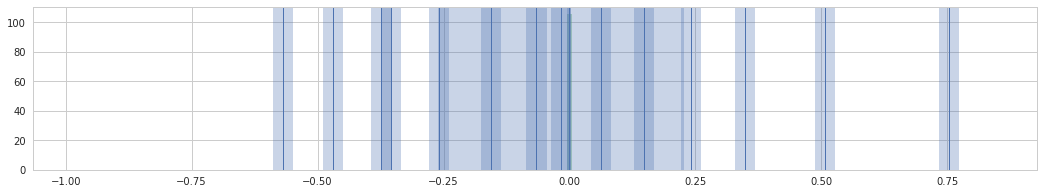

**Epoch: 100**

Layer Loss: -756932.562
Layer Loss: -407.561
Layer Loss: -64688.059
Layer Loss: -56.813
Layer Loss: 6509.513
Layer Loss: 16.749
0-neglogprop Loss: 76104.891
Remaining-neglogprop Loss: -24474.273
Epoch: 100. Loss: 1.4737887382507324. Accuracy: 97.95
Means: [-0.354, -0.569, -0.47, -0.373, -0.258, -0.156, -0.066, -0.017, 0.063, 0.148, 0.241, 0.349, 0.507, -0.016, 0.753]
Mixing Proportions: [-3.019, -8.703, -9.488, -9.48, -9.418, -9.346, -9.298, -9.286, -9.316, -9.388, -9.478, -9.52, -9.921, 11.484, -6.544]
Precisions: [11.094, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 7.82, 2.815, 7.82]


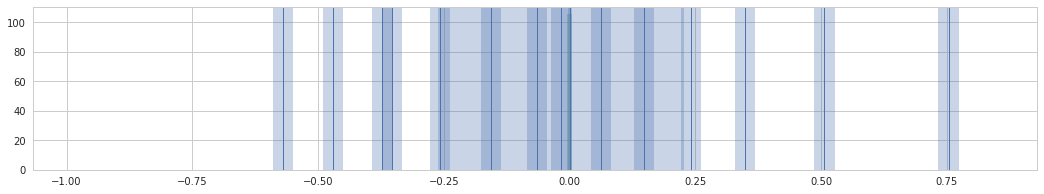

In [25]:
#model = models.LeNet_300_100().cuda()
#print_dims(model)
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99)
sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
optimizer_gmp = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='original_model/'

for epoch in range(100):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
    model, loss = train_epoch_sws(model, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 1)):
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
        show_sws_weights(model, list(gmp.means.data.clone().cpu()), list(gmp.gammas.data.clone().cpu()))
    

#torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

### 2. Re-train Model

**Temperature = 1**

Epoch: 20. Train CE Loss: 1.513, Train Accuracy: 99.037, Test CE Loss: 1.519, Test Accuracy: 97.990, Model L2: 18.815
Epoch: 40. Train CE Loss: 1.512, Train Accuracy: 99.055, Test CE Loss: 1.517, Test Accuracy: 98.040, Model L2: 18.733


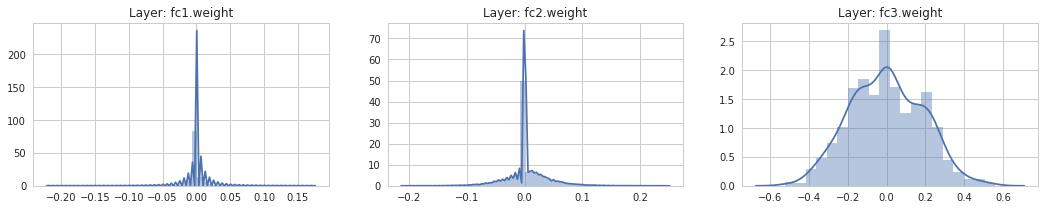

**Temperature = 5**

Epoch: 20. Train CE Loss: 1.516, Train Accuracy: 98.848, Test CE Loss: 1.522, Test Accuracy: 97.810, Model L2: 18.595
Epoch: 40. Train CE Loss: 1.514, Train Accuracy: 98.950, Test CE Loss: 1.520, Test Accuracy: 98.010, Model L2: 18.491


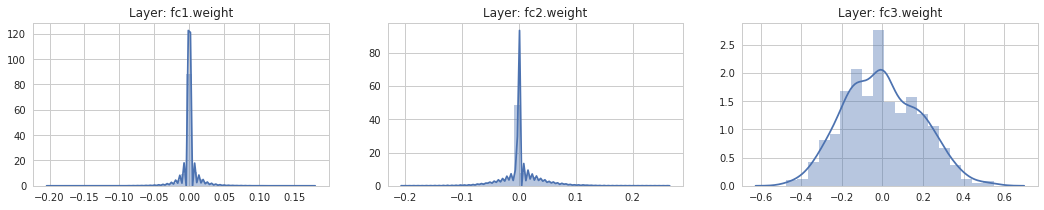

**Temperature = 10**

Epoch: 20. Train CE Loss: 1.531, Train Accuracy: 98.688, Test CE Loss: 1.534, Test Accuracy: 97.950, Model L2: 17.576
Epoch: 40. Train CE Loss: 1.529, Train Accuracy: 98.710, Test CE Loss: 1.532, Test Accuracy: 97.850, Model L2: 17.509


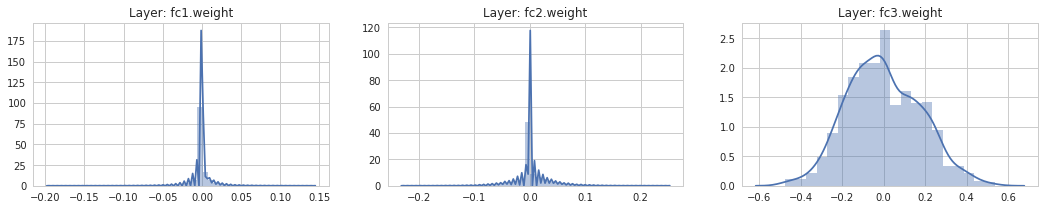

**Temperature = 15**

Epoch: 20. Train CE Loss: 1.576, Train Accuracy: 98.330, Test CE Loss: 1.575, Test Accuracy: 97.680, Model L2: 16.114
Epoch: 40. Train CE Loss: 1.575, Train Accuracy: 98.407, Test CE Loss: 1.575, Test Accuracy: 97.670, Model L2: 16.017


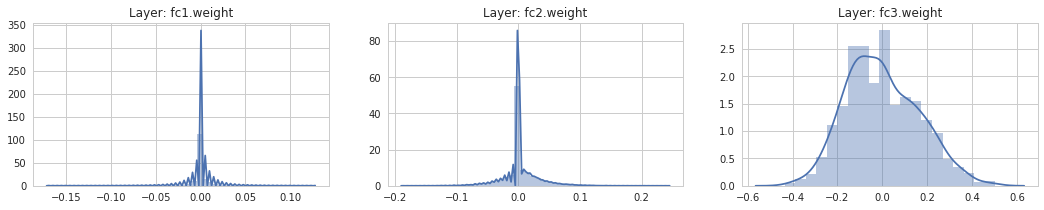

**Temperature = 20**

Epoch: 20. Train CE Loss: 1.648, Train Accuracy: 97.995, Test CE Loss: 1.645, Test Accuracy: 97.490, Model L2: 14.677
Epoch: 40. Train CE Loss: 1.648, Train Accuracy: 98.038, Test CE Loss: 1.644, Test Accuracy: 97.480, Model L2: 14.611


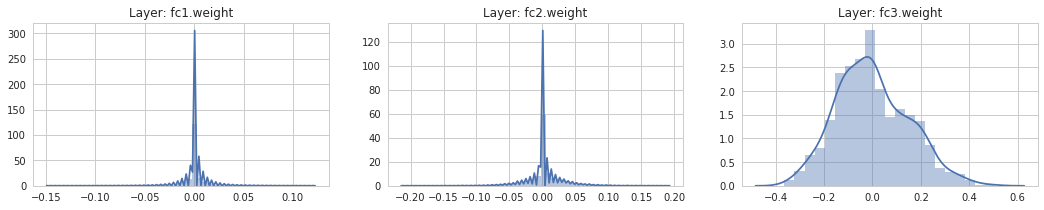

**Temperature = 25**

Epoch: 20. Train CE Loss: 1.729, Train Accuracy: 97.690, Test CE Loss: 1.724, Test Accuracy: 97.310, Model L2: 13.517
Epoch: 40. Train CE Loss: 1.727, Train Accuracy: 97.895, Test CE Loss: 1.722, Test Accuracy: 97.500, Model L2: 13.511


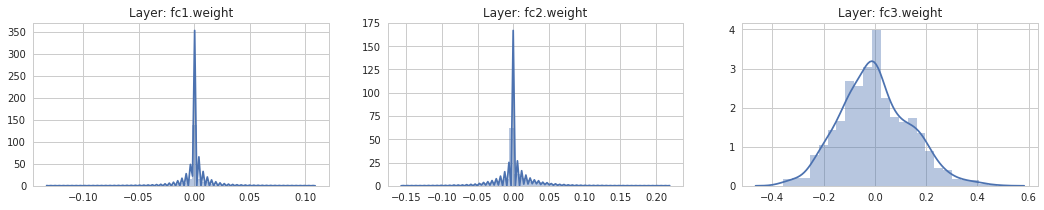

**Temperature = 30**

Epoch: 20. Train CE Loss: 1.806, Train Accuracy: 97.617, Test CE Loss: 1.800, Test Accuracy: 97.280, Model L2: 12.557
Epoch: 40. Train CE Loss: 1.806, Train Accuracy: 97.635, Test CE Loss: 1.801, Test Accuracy: 97.220, Model L2: 12.561


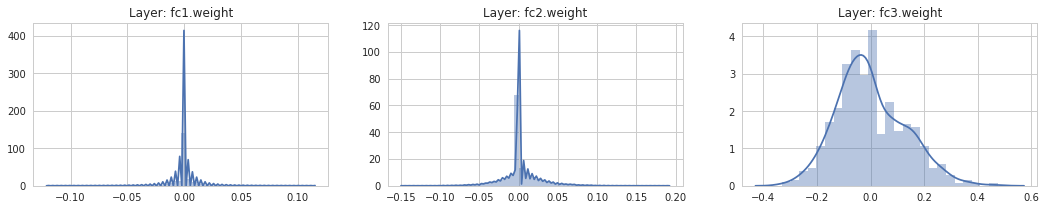

In [3]:
#Get KD Targets   
for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
    kd_outputs = model.kd_targets(train_data_full,T=temp)
    kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
    train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T_{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_data_full, test_labels_full, model_kd)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_kd)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'train_CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'train_Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'train_L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%20==19):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

### 3. Prune Model

**Temperature = 1**

Train CE Loss: 1.862, Train Accuracy: 89.627, Test CE Loss: 1.857, Test Accuracy: 88.930, Model L2: 16.345, Parameters Pruned: 235301/266610 - 88.257%
Train CE Loss: 1.929, Train Accuracy: 85.725, Test CE Loss: 1.924, Test Accuracy: 84.600, Model L2: 16.124, Parameters Pruned: 226270/266610 - 84.869%


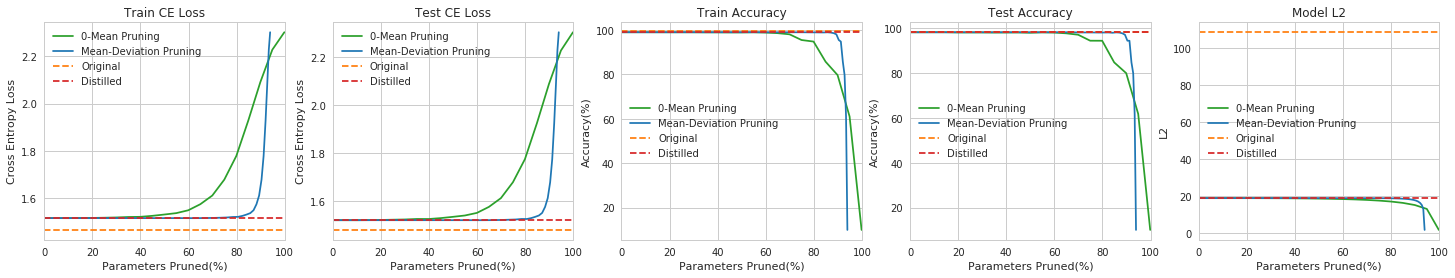

**Temperature = 5**

Train CE Loss: 1.848, Train Accuracy: 84.250, Test CE Loss: 1.844, Test Accuracy: 83.450, Model L2: 16.239, Parameters Pruned: 235622/266610 - 88.377%
Train CE Loss: 1.897, Train Accuracy: 82.622, Test CE Loss: 1.894, Test Accuracy: 81.950, Model L2: 15.949, Parameters Pruned: 226270/266610 - 84.869%


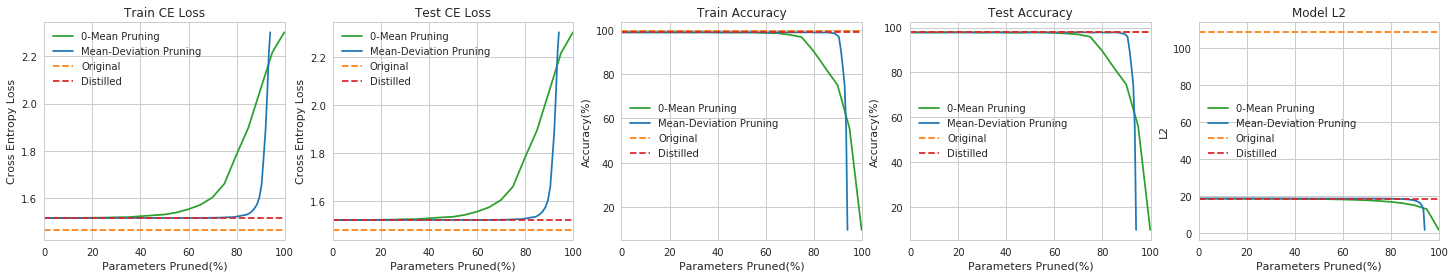

**Temperature = 10**

Train CE Loss: 1.869, Train Accuracy: 90.467, Test CE Loss: 1.861, Test Accuracy: 89.800, Model L2: 15.362, Parameters Pruned: 235608/266610 - 88.372%
Train CE Loss: 1.926, Train Accuracy: 92.660, Test CE Loss: 1.919, Test Accuracy: 91.990, Model L2: 15.180, Parameters Pruned: 226270/266610 - 84.869%


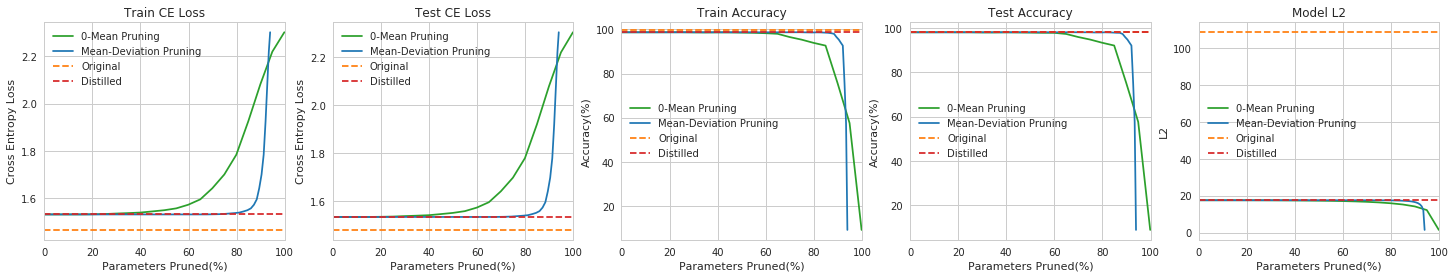

**Temperature = 15**

Train CE Loss: 1.928, Train Accuracy: 90.552, Test CE Loss: 1.922, Test Accuracy: 90.050, Model L2: 14.014, Parameters Pruned: 236170/266610 - 88.583%
Train CE Loss: 1.983, Train Accuracy: 84.900, Test CE Loss: 1.978, Test Accuracy: 84.110, Model L2: 13.849, Parameters Pruned: 226270/266610 - 84.869%


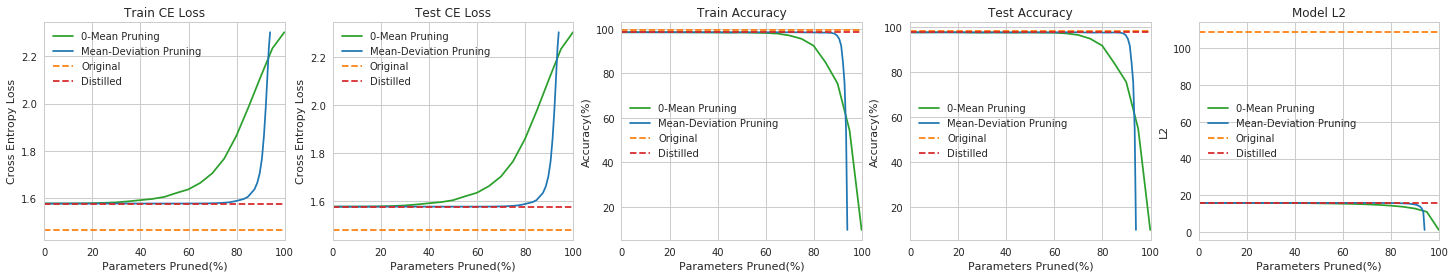

**Temperature = 20**

Train CE Loss: 1.981, Train Accuracy: 88.742, Test CE Loss: 1.975, Test Accuracy: 88.460, Model L2: 12.907, Parameters Pruned: 235772/266610 - 88.433%
Train CE Loss: 2.024, Train Accuracy: 87.882, Test CE Loss: 2.019, Test Accuracy: 87.350, Model L2: 12.730, Parameters Pruned: 226270/266610 - 84.869%


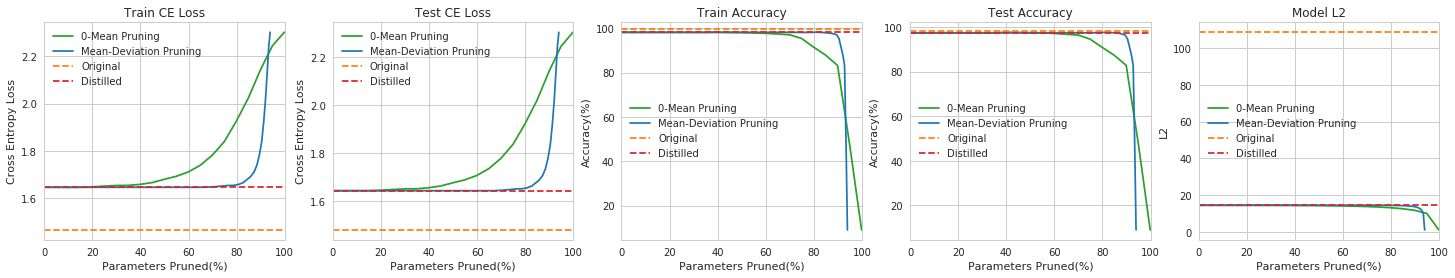

**Temperature = 25**

Train CE Loss: 2.031, Train Accuracy: 86.620, Test CE Loss: 2.025, Test Accuracy: 86.660, Model L2: 11.936, Parameters Pruned: 234994/266610 - 88.141%
Train CE Loss: 2.072, Train Accuracy: 83.885, Test CE Loss: 2.066, Test Accuracy: 83.910, Model L2: 11.764, Parameters Pruned: 226270/266610 - 84.869%


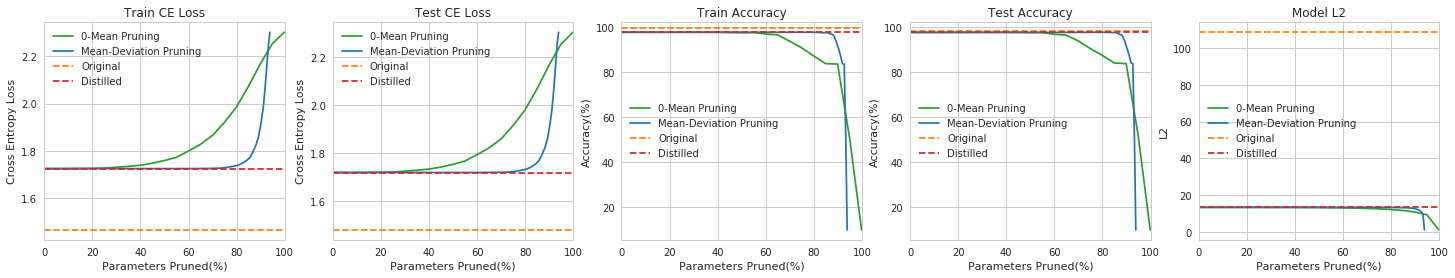

**Temperature = 30**

Train CE Loss: 2.100, Train Accuracy: 94.078, Test CE Loss: 2.096, Test Accuracy: 93.550, Model L2: 11.047, Parameters Pruned: 234621/266610 - 88.002%
Train CE Loss: 2.117, Train Accuracy: 88.603, Test CE Loss: 2.114, Test Accuracy: 88.120, Model L2: 10.959, Parameters Pruned: 226270/266610 - 84.869%


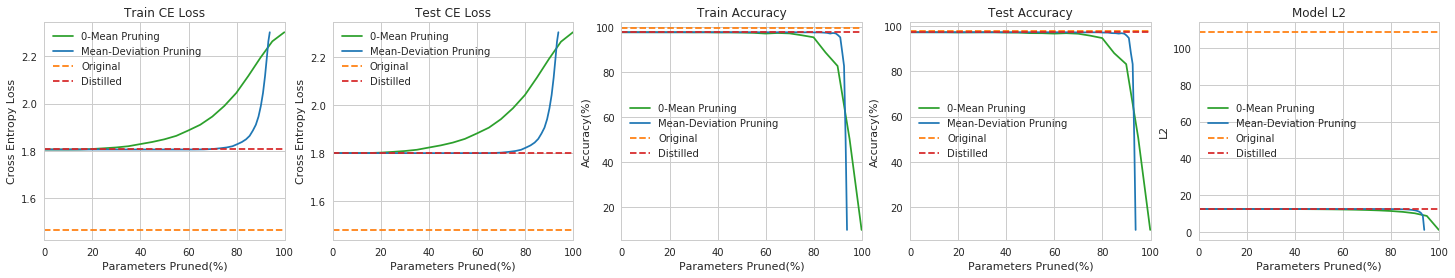

In [4]:
#Original Model
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
test_acc_o = test_accuracy(test_data_full, test_labels_full, model)
train_acc_o = test_accuracy(train_data_full, train_labels_full, model)
weight_penalty_o = get_weight_penalty(model)
compress_res = {}

for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    graph_title = "compressed_model_T_{}/".format(temp)
    #Retrained Model
    model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e50.m'.format(temp)).cuda()
    test_acc_kd = test_accuracy(test_data_full, test_labels_full, model_kd)
    train_acc_kd = test_accuracy(train_data_full, train_labels_full, model_kd)
    weight_penalty_kd = get_weight_penalty(model_kd)
    
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)
    
    model_c = models.LeNet_300_100().cuda()
    pruner = model_prune(model_kd.state_dict())
    deviation_list = [x/10.0 for x in range(0,21)]
    percentile_list = range(0,101,5)
    
    
    dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
    for i,lim in enumerate(deviation_list):
        model_c.load_state_dict(pruner.deviation_prune(lim))
        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)

        dev_res['train ce'].append(train_acc[1])
        dev_res['test ce'].append(test_acc[1])
        dev_res['train acc'].append(train_acc[0])
        dev_res['test acc'].append(test_acc[0])
        dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        dev_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)

        if(i==13):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
    
    perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 
    for i,lim in enumerate(percentile_list):
        model_c.load_state_dict(pruner.percentile_prune(lim))

        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)
        perc_res['train ce'].append(train_acc[1])
        perc_res['test ce'].append(test_acc[1])
        perc_res['train acc'].append(train_acc[0])
        perc_res['test acc'].append(test_acc[0])
        perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        perc_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
        
        if(i==17):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
            
    prune_plot(temp, dev_res, perc_res, test_acc_o, train_acc_o, weight_penalty_o, test_acc_kd, train_acc_kd, weight_penalty_kd)
    #t_res={} 
    #t_res['dev']=dev_res
    #t_res['perc']=perc_res
    #compress_res[temp]=t_res